## Introduction
### Project Objective
The goal of this project is to build a machine learning model to classify the intensity of emotions (anger, happiness, sadness) in text reviews. By leveraging NLP techniques, the model will help analyze text data effectively and improve customer satisfaction by understanding emotional feedback.

## Importing Necessary Libraries

In [1]:
!pip install keras-tuner --upgrade

In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import joblib
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
import re
import string
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
from collections import Counter
from wordcloud import WordCloud

# Importing tensorflow and keras libraries for Deep Learning
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional, Conv1D, MaxPooling1D, Flatten
import keras_tuner
from keras_tuner import HyperModel, RandomSearch

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Loading the Dataset
This dataset contains 3 different csv files of different emotions. Let's load one by one and concat them together.

### Angriness Data Loading and EDA

In [3]:
# First we load angriness.csv file and check for the data.
angry_df = pd.read_csv("/content/drive/MyDrive/Upgrad_bootcamp/Final Capstone/Intensity_Analysis_Project/Data_Sets/Raw_data/Intensity_data/angriness.csv")
angry_df.head()

,content,intensity
0,"Sometimes I’m not angry, I’m hurt and there’s ...",angriness
1,Not available for busy people☺,angriness
2,I do not exist to impress the world. I exist t...,angriness
3,Everything is getting expensive except some pe...,angriness
4,My phone screen is brighter than my future 🙁,angriness


In [4]:
# Checking the shape of the dataframe
angry_df.shape

(696, 2)

In [5]:
# Checking for null values in the data
angry_df.isnull().sum()

,0
content,0
intensity,0


In [6]:
# Checking for duplicate values
angry_df.duplicated().sum()

198

### Happiness Data Loading and EDA

In [7]:
# Loading happiness.csv file and checking for the data.
happy_df = pd.read_csv("/content/drive/MyDrive/Upgrad_bootcamp/Final Capstone/Intensity_Analysis_Project/Data_Sets/Raw_data/Intensity_data/happiness.csv")
happy_df.head()

,content,intensity
0,Wants to know how the hell I can remember word...,happiness
1,Love is a long sweet dream & marriage is an al...,happiness
2,The world could be amazing when you are slight...,happiness
3,My secret talent is getting tired without doin...,happiness
4,"Khatarnaak Whatsapp Status Ever… Can\’t talk, ...",happiness


In [8]:
# Checking the shape of the dataframe
happy_df.shape

(708, 2)

In [9]:
# Checking for null values in the data
happy_df.isnull().sum()

,0
content,0
intensity,0


In [10]:
# Checking for duplicate values
happy_df.duplicated().sum()

4

### Sadness Data Loading and EDA

In [11]:
# Loading sadness.csv file and checking for the data.
sad_df = pd.read_csv("/content/drive/MyDrive/Upgrad_bootcamp/Final Capstone/Intensity_Analysis_Project/Data_Sets/Raw_data/Intensity_data/sadness.csv")
sad_df.head()

,content,intensity
0,"Never hurt people who love you a lot, because ...",sadness
1,Don’t expect me to tell you what you did wrong...,sadness
2,I preferred walking away than fighting for you...,sadness
3,"Moving forward in life isn’t the hard part, it...",sadness
4,"Never cry for anyone in your life, because tho...",sadness


In [12]:
# Checking the shape of the dataframe
sad_df.shape

(635, 2)

In [13]:
# Checking for null values in the data
sad_df.isnull().sum()

,0
content,0
intensity,0


In [14]:
# Checking for duplicate values
sad_df.duplicated().sum()

245

### Final Dataset with all the three csv files

In [15]:
# Now let's concat all the dataframes into single and final dataframe on which we are going to work
# Concating them row wise
df = pd.concat([angry_df, happy_df, sad_df], ignore_index=True)
df.head()  # Glimpse of the final data

,content,intensity
0,"Sometimes I’m not angry, I’m hurt and there’s ...",angriness
1,Not available for busy people☺,angriness
2,I do not exist to impress the world. I exist t...,angriness
3,Everything is getting expensive except some pe...,angriness
4,My phone screen is brighter than my future 🙁,angriness


In [16]:
# Let's try with sample for better view of all the three intensities
df.sample(10)

,content,intensity
2037,"Sometimes you have to hold your head up high, ...",sadness
1397,If you would learn the secret of right relatio...,happiness
415,It sucks when you realise you rejected other p...,angriness
1457,The most important part of moving on is lettin...,sadness
1093,Success is about how high you jump when you hi...,happiness
60,"I am simple, complex, generous, selfish, unatt...",angriness
1242,"Some love one, some love two. I love one that ...",happiness
648,There are no words to describe the anger and f...,angriness
888,Theres no fun in a perfect life. So make a ris...,happiness
378,"Stop being so negative, go see a psychiatrist ...",angriness


In [17]:
# Saving the dataset as csv file before the preprocessing
# File path where we want to save the file
file_path = os.path.join("/content/drive/MyDrive/Upgrad_bootcamp/Final Capstone/Intensity_Analysis_Project/Data_Sets/Processed_data", "concated_data.csv")

# Saving the df dataframe as a csv file
df.to_csv(file_path, index=False)  # Set index=False to avoid saving the DataFrame index

## Exploratory Data Analysis

In [18]:
# Checking the shape of the data
df.shape

(2039, 2)

In [19]:
# Quick overview of the data set
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2039 entries, 0 to 2038
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   content    2039 non-null   object
 1   intensity  2039 non-null   object
dtypes: object(2)
memory usage: 32.0+ KB


In [20]:
# Checking for missing values
df.isnull().sum()

,0
content,0
intensity,0


As we can see there no null values present in the data.

In [21]:
# Checking for the duplicated values
df.duplicated().sum()

447

As the dataset size is small and duplicates might add some variability in real-world scenario. So, here I am continuing without dropping the duplicates.

In [22]:
# File to save the visualizations of the data in a seperate folder for future references.
visualization_folder = "/content/drive/MyDrive/Upgrad_bootcamp/Final Capstone/Intensity_Analysis_Project/Visualizations"

### Analyzing the Target Column (intensity)
#### Class Distribution

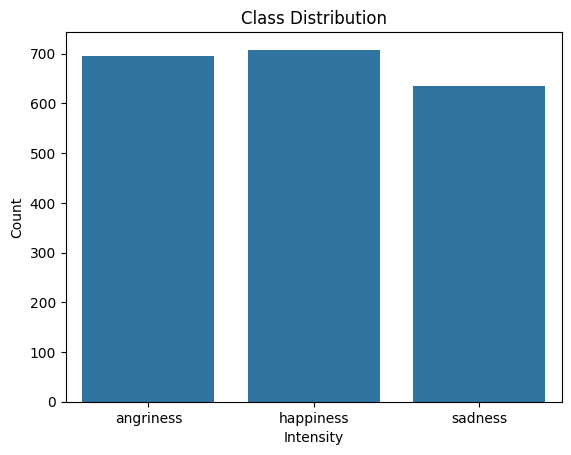

intensity
happiness    708
angriness    696
sadness      635
Name: count, dtype: int64


In [23]:
# Class distribution visualization
sns.countplot(data=df, x='intensity')
plt.title("Class Distribution")
plt.xlabel("Intensity")
plt.ylabel("Count")
plt.savefig(os.path.join(visualization_folder, "class_distribution_visualization.png"))
plt.show()

# Numeric summary of class distribution
print(df['intensity'].value_counts())

As we can see there is no class imbalance in the dataset.

### Analyzing the Text Column (content)
#### Basic Statistics of Text

In [24]:
# Adding a column for text length
df['text_length'] = df['content'].apply(lambda x: len(x.split()))

# Summary statistics for text length
print(df['text_length'].describe())

count    2039.000000
mean      228.156449
std       605.453023
min         1.000000
25%        10.000000
50%        14.000000
75%        20.000000
max      2165.000000
Name: text_length, dtype: float64


In [25]:
df.sample(5)

,content,intensity,text_length
1990,"['You Hurt Me But I Still Love You.', 'True Lo...",sadness,2165
1564,Don't play with my heart if you have no intent...,sadness,14
1101,"I can see the future , Let me give you a Clue ...",happiness,19
1085,"I can’t give you the formula for success, but ...",happiness,24
1140,My heart is perfect because.. you are inside.,happiness,8


### Text Length Distribution


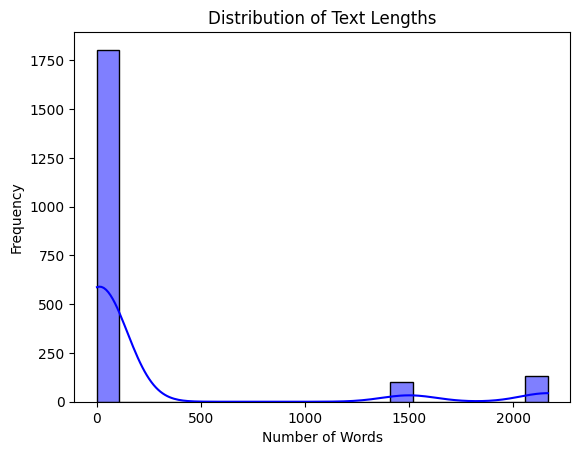

In [26]:
# Distribution of text length
sns.histplot(df['text_length'], bins=20, kde=True, color='blue')
plt.title("Distribution of Text Lengths")
plt.xlabel("Number of Words")
plt.ylabel("Frequency")
plt.savefig(os.path.join(visualization_folder, "distribution_of_text_lengths.png"))
plt.show()

The number of words and their frequency is shown in the above plot, we see few words are repeated most number of times.

### Text Length Per Category

intensity
angriness    227.591954
happiness     13.440678
sadness      468.174803
Name: text_length, dtype: float64


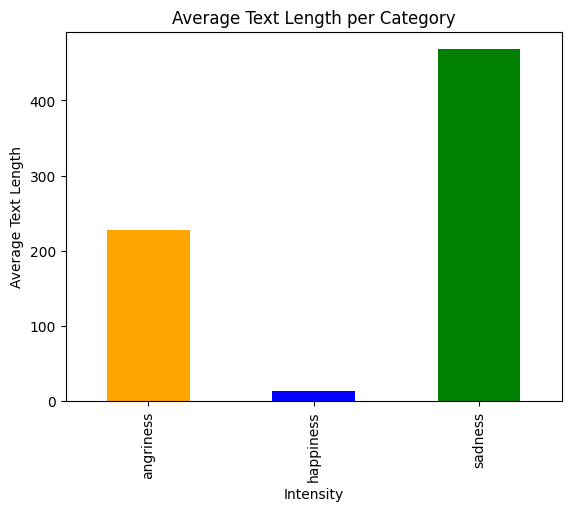

In [27]:
# Group by category and calculating average text length
avg_length_per_category = df.groupby('intensity')['text_length'].mean()
print(avg_length_per_category)
# Bar plot for average text length by category
avg_length_per_category.plot(kind='bar', color=['orange', 'blue', 'green'])
plt.title("Average Text Length per Category")
plt.xlabel("Intensity")
plt.ylabel("Average Text Length")
plt.savefig(os.path.join(visualization_folder, "average_text_length_per_category.png"))
plt.show()

Number of words in the content of different intensties varies as shown above. Texts belongs to happiness are of less words compared to angriness comapred to sadness.

### Wordcloud Visualization
Visualizing word frequency using word clouds.

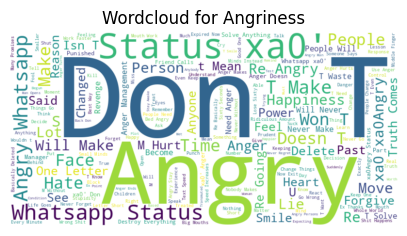

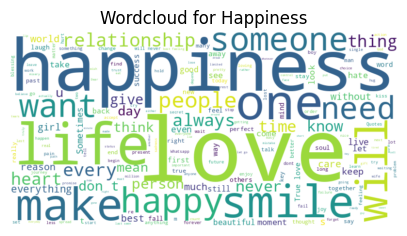

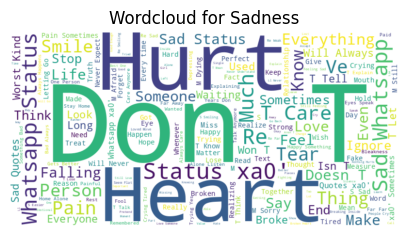

In [28]:
# Generating word clouds for each category
categories = df['intensity'].unique()
for category in categories:
    text = ' '.join(df[df['intensity'] == category]['content'])
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(5, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f"Wordcloud for {category.capitalize()}")
    plt.axis('off')
    plt.savefig(os.path.join(visualization_folder, f"wordcloud_{category}.png"))
    plt.show()


From the above word clouds, we can see the most repeated words for each category.

## Data Preprocessing:
### Working on content Column:
To clean and preprocess the content column, we follow below steps:

#### Steps to Clean the Text:
1. Lowercase Conversion: Convert all text to lowercase.
2. Remove Punctuation: Eliminate punctuation marks.
3. Remove Numbers: Remove digits from the text.
4. Remove Stopwords: Remove common words like "and," "the," etc., using NLTK's stopwords.
5. Tokenization: Split the text into words (optional for more control).
6. Lemmatization: Convert words to their base forms.

In [29]:
# Initializing NLTK tools
lemmatizer = WordNetLemmatizer()
stop_words = nltk.corpus.stopwords.words('english')
# removing certain words in the stopwords, so that meaning of the sentence doesn't change
stop_words.remove('no')
stop_words.remove('not')
stop_words.remove('but')

In [30]:
# Function to clean description
def clean_content(text):
    # Convert to lowercase
    text = text.lower()
    # Remove special characters, punctuation, and numbers
    text = re.sub(r'[^a-z\s]', '', text)
    # Tokenize and remove stopwords
    words = text.split()
    words = [word for word in words if word not in stop_words]
    # Lemmatize each word
    words = [lemmatizer.lemmatize(word) for word in words]
    # Join back into a single string
    return ' '.join(words)

In [31]:
# Applying the preprocess_text function on the content column
df['cleaned_content'] = df['content'].apply(clean_content)

In [32]:
# Checking the dataframe after preprocessing
df.head()

,content,intensity,text_length,cleaned_content
0,"Sometimes I’m not angry, I’m hurt and there’s ...",angriness,11,sometimes im not angry im hurt there big diffe...
1,Not available for busy people☺,angriness,5,not available busy people
2,I do not exist to impress the world. I exist t...,angriness,22,not exist impress world exist live life way ma...
3,Everything is getting expensive except some pe...,angriness,11,everything getting expensive except people get...
4,My phone screen is brighter than my future 🙁,angriness,9,phone screen brighter future


In [33]:
# Adding the cleaned_length column based on the cleaned content
df['cleaned_length'] = df['cleaned_content'].apply(lambda text: len(text.split()))

In [34]:
df.head()

,content,intensity,text_length,cleaned_content,cleaned_length
0,"Sometimes I’m not angry, I’m hurt and there’s ...",angriness,11,sometimes im not angry im hurt there big diffe...,9
1,Not available for busy people☺,angriness,5,not available busy people,4
2,I do not exist to impress the world. I exist t...,angriness,22,not exist impress world exist live life way ma...,10
3,Everything is getting expensive except some pe...,angriness,11,everything getting expensive except people get...,7
4,My phone screen is brighter than my future 🙁,angriness,9,phone screen brighter future,4


## EDA Steps After Preprocessing
Plotting the distribution based on the length of the reveiews for each intensity after cleaning

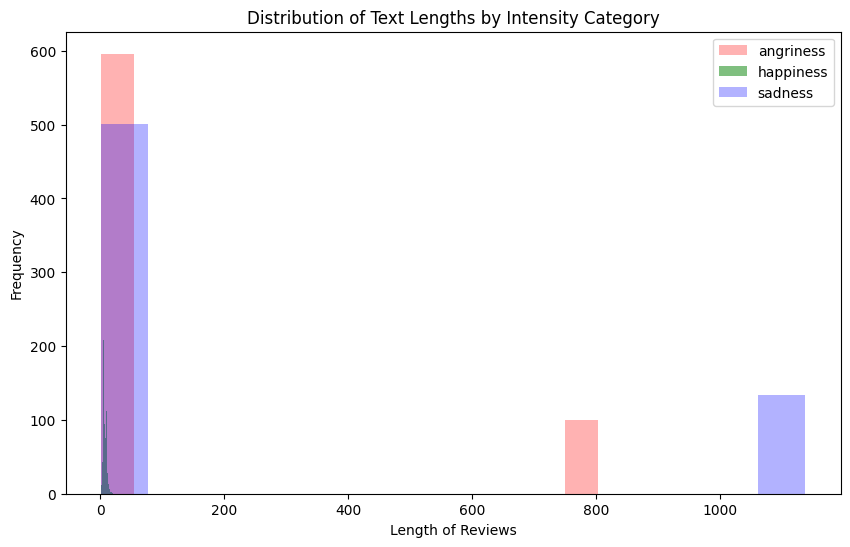

In [35]:
# Plotting histograms for word length by intensity category
plt.figure(figsize=(10, 6))
df[df['intensity'] == 'angriness']['cleaned_length'].plot.hist(bins=15, alpha=0.3, label="angriness", color='red')
df[df['intensity'] == 'happiness']['cleaned_length'].plot.hist(bins=15, alpha=0.5, label="happiness", color='green')
df[df['intensity'] == 'sadness']['cleaned_length'].plot.hist(bins=15, alpha=0.3, label="sadness", color='blue')
plt.xlabel("Length of Reviews")
plt.ylabel("Frequency")
plt.title("Distribution of Text Lengths by Intensity Category")
plt.legend()
plt.savefig(os.path.join(visualization_folder, "distribution_of_text_lengths_by_category.png"))
plt.show()

As we can see the word count is reduced after preprocessing.

### Top Words by Frequency
Identifying the most common words in the cleaned text.

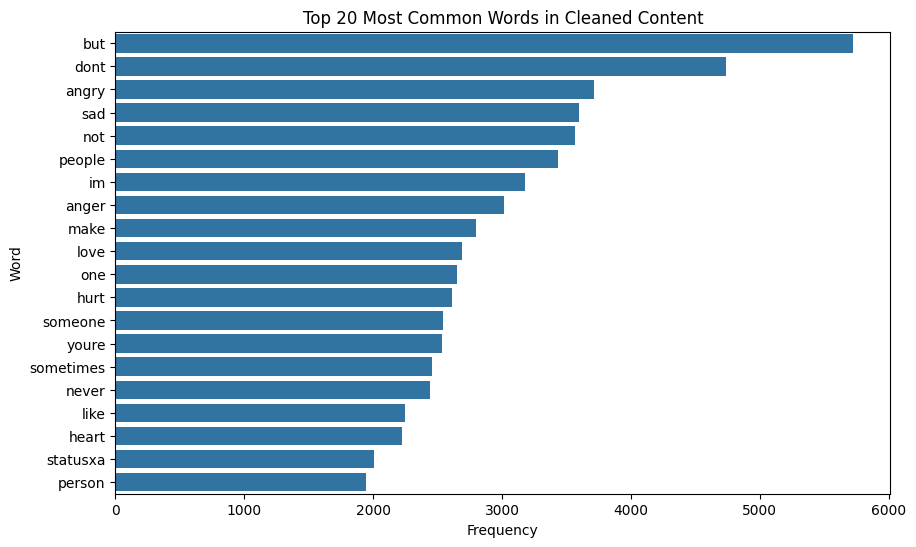

In [36]:
# Flattening all words into a single list
all_words = ' '.join(df['cleaned_content']).split()
# Count of word frequencies
word_counts = Counter(all_words)
most_common_words = word_counts.most_common(20)
# Converting to a DataFrame for visualization
word_freq_df = pd.DataFrame(most_common_words, columns=['Word', 'Frequency'])
# Plotting the most common words
plt.figure(figsize=(10, 6))
sns.barplot(data=word_freq_df, x='Frequency', y='Word')
plt.title('Top 20 Most Common Words in Cleaned Content')
plt.xlabel('Frequency')
plt.ylabel('Word')
plt.savefig(os.path.join(visualization_folder, "top_20_most_common_words.png"))
plt.show()

From the above bar chart, we can see the top 20 most common words in cleaned content against their frequency.

### Word Count Per Category
Comparing the average word count in each intensity category (angriness, happiness, sadness).

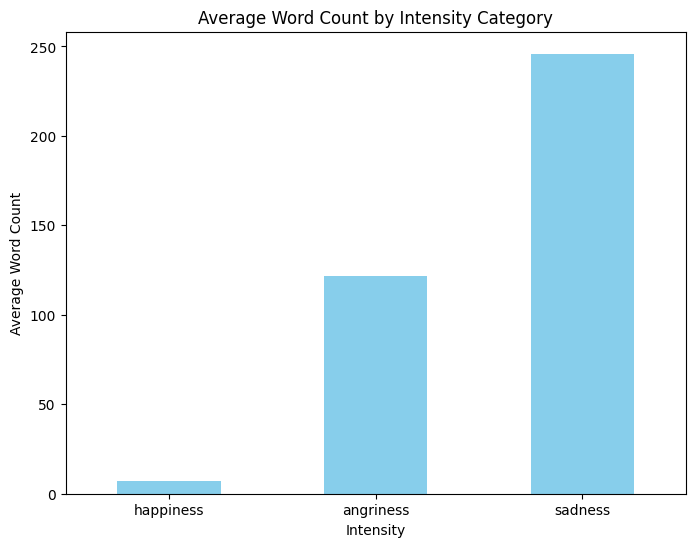

In [37]:
# Calculating average word count for each category
category_word_counts = df.groupby('intensity')['cleaned_length'].mean()

# Average word count per category plot
plt.figure(figsize=(8, 6))
category_word_counts.sort_values().plot(kind='bar', color='skyblue')
plt.title('Average Word Count by Intensity Category')
plt.xlabel('Intensity')
plt.ylabel('Average Word Count')
plt.xticks(rotation=0)
plt.savefig(os.path.join(visualization_folder, "average_word_count_by_category.png"))
plt.show()

Number of words in the content of different intensties varies as shown above. Texts belongs to happiness are of less words compared to angriness comapred to sadness which remains of same even after preprocessing.

### Word Cloud for Each Category
Generating a word cloud for each intensity category to visualize the dominant words.

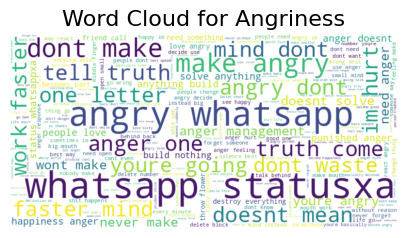

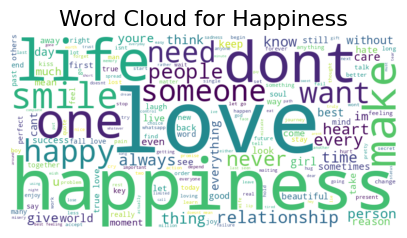

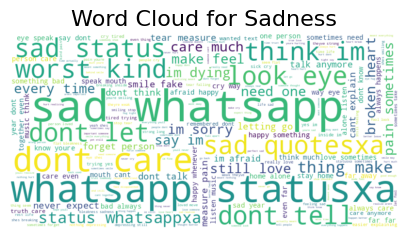

In [38]:
# Function to generate a word cloud
def generate_wordcloud(text, title):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(5, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title, fontsize=16)
    plt.savefig(os.path.join(visualization_folder, f"wordcloud_{title}_after_preprocessing.png"))
    plt.show()

# Generating word clouds for each category
for category in df['intensity'].unique():
    category_text = ' '.join(df[df['intensity'] == category]['cleaned_content'])
    generate_wordcloud(category_text, f"Word Cloud for {category.capitalize()}")


From the above word clouds, we can see the most repeated words for each category after preprocessing.

### Changes in Text Characteristics
Examining how preprocessing impacted specific characteristics like unique words and stopword removal.

In [39]:
# Calculate unique word count before and after cleaning
original_unique_words = set(' '.join(df['content']).split())
cleaned_unique_words = set(' '.join(df['cleaned_content']).split())

print("Number of unique words in original content:", len(original_unique_words))
print("Number of unique words in cleaned content:", len(cleaned_unique_words))
print("Reduction in unique words after cleaning:", len(original_unique_words) - len(cleaned_unique_words))

Number of unique words in original content: 5100
Number of unique words in cleaned content: 2262
Reduction in unique words after cleaning: 2838


From the above values, we can observe that the unique words count reduced from 5100 to 2262 after preprcessing. It's almost 55% reduction.

## Splitting the Data into Train and Test
We should split the data before vectorization to avoid "data leakage." If we perform vectorization before splitting, the vectorizer may learn information from the entire dataset, including the test set, which can bias your results.

In [40]:
# Encoding target labels (intensity categories)
label_encoder = LabelEncoder()
df['intensity_encoded'] = label_encoder.fit_transform(df['intensity'])

In [41]:
# Separating features and target
X = df['cleaned_content']
y = df['intensity_encoded']

In [42]:
# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [43]:
# Checking the shapes of the resulting splits
print("Training feature set size:", X_train.shape)
print("Testing feature set size:", X_test.shape)
print("Training target set size:", y_train.shape)
print("Testing target set size:", y_test.shape)

Training feature set size: (1631,)
Testing feature set size: (408,)
Training target set size: (1631,)
Testing target set size: (408,)


In [44]:
print(y_train.value_counts())
print(y_test.value_counts())

intensity_encoded
1    566
0    557
2    508
Name: count, dtype: int64
intensity_encoded
1    142
0    139
2    127
Name: count, dtype: int64


## Vectorization:
Here I am applying TF-IDF Vectorizer.

TF-IDF Vectorization to convert text data into numerical feature vectors, which can be used as input for machine learning models.

The TF-IDF Vectorizer (Term Frequency-Inverse Document Frequency) is a popular technique in Natural Language Processing (NLP) used to convert text into numerical features based on the importance of words in a document relative to a collection of documents (corpus).

- **When to Use TF-IDF:**
TF-IDF is most effective when you're working on text classification tasks, such as sentiment analysis, spam detection, and topic classification. It is also commonly used in information retrieval systems, where the goal is to retrieve the most relevant documents based on query terms.

- **Significance of TF-IDF in NLP:**
1. **Capturing Importance:** TF-IDF focuses on identifying words that are meaningful in the context of a specific document while down-weighting words that appear frequently across many documents (e.g., "the", "and", etc.). This makes it ideal for tasks where identifying the most significant words is crucial, such as in text classification or information retrieval.
2. **Improving Model Performance:** By using TF-IDF, models can learn better from words that truly represent the content of a document, leading to improved performance in text-based tasks. Words with higher TF-IDF scores are considered more relevant to the meaning of the document, making them more impactful for machine learning models.
3. **Efficient Representation:** TF-IDF provides a sparse, efficient vector representation of text, making it easier to apply machine learning algorithms.

In [45]:
# Initializing TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')

In [46]:
# Fitting on training data and transform both train and test sets
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

In [47]:
# Displaying the shapes of the resulting vectorized data
print("TF-IDF training set shape:", X_train_tfidf.shape)
print("TF-IDF testing set shape:", X_test_tfidf.shape)

TF-IDF training set shape: (1631, 1903)
TF-IDF testing set shape: (408, 1903)


## Model Selection & Model Building:
For text classification projects, common options include:
1. Logistic Regression
2. Support Vector Machines (SVM)
3. Naive Bayes
4. K Neighbors Classifier
5. Decision Tree Classifier
6. Random Forest Classifier

### Evaluation Metrics:
Accuracy, precision, recall, F1 score, classification report.
Confusion matrix with category names.

### Hyperparameter Tuning:
Optimizing models using grid search for parameters like learning rate, regularization, and depth.

Before continuing with models, let's create a dataframe as the score-card for comparing the scores of different models after building and hypertuning.

In [48]:
# Initializing the score_card with specified column names and data types
score_card = pd.DataFrame(columns=['Model Name', 'Accuracy Score', 'Precision Score', 'Recall Score', 'F1 Score'])

# Function to update the score_card
def update_score_card(y_test, y_pred, model_name):
    """
    Updates the score_card DataFrame with performance metrics for a given model.
    """
    global score_card

    # Creating a new row with the metrics
    new_row = pd.DataFrame([{
        'Model Name': model_name,
        'Accuracy Score': accuracy_score(y_test, y_pred),
        'Precision Score': precision_score(y_test, y_pred, average="weighted"),
        'Recall Score': recall_score(y_test, y_pred, average="weighted"),
        'F1 Score': f1_score(y_test, y_pred, average="weighted")
    }])

    # Appending the new row to the score_card
    score_card = pd.concat([score_card, new_row], ignore_index=True)

### 1. Logistic Regression Model
A simple and efficient model for text classification.
Works well with high-dimensional data like text after TF-IDF or Count Vectorization.
Fast to train and interpret.

In [49]:
# Initializing the logistic regression model
lr = LogisticRegression(max_iter=1000)
# Fitting the model on the training data
lr.fit(X_train_tfidf, y_train)
# Predicting on test data
y_pred_lr = lr.predict(X_test_tfidf)

In [50]:
# Using accuracy_score() for checking the accuracy on the test data
accuracy_score(y_test,y_pred_lr)

0.7549019607843137

In [51]:
# Classification Report of Logistic Regression
print("Logistic Regression - Classification Report")
print(classification_report(y_test, y_pred_lr))

Logistic Regression - Classification Report
              precision    recall  f1-score   support

           0       0.78      0.82      0.80       139
           1       0.75      0.75      0.75       142
           2       0.73      0.69      0.71       127

    accuracy                           0.75       408
   macro avg       0.75      0.75      0.75       408
weighted avg       0.75      0.75      0.75       408



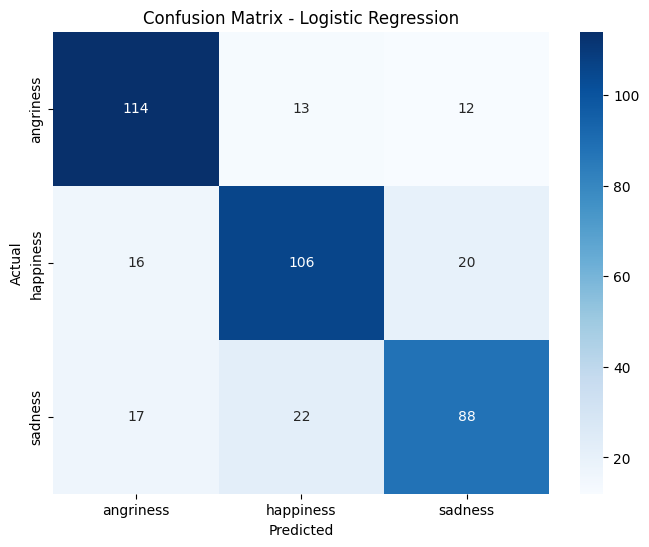

In [52]:
# Confusion Matrix of Logistic Regression
# category names from the encoder
category_names = label_encoder.classes_
cm_lr = confusion_matrix(y_test, y_pred_lr)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Blues', xticklabels=category_names, yticklabels=category_names)
plt.title("Confusion Matrix - Logistic Regression")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.savefig(os.path.join(visualization_folder, "confusion_matrix_logistic_regression.png"))
plt.show()

In [53]:
# Update score card for Logistic Regression
update_score_card(y_test, y_pred_lr, "Logistic Regression")

<ipython-input-48-fe5dd96a7645>:21: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  score_card = pd.concat([score_card, new_row], ignore_index=True)


### Hyperparameter Tuning - Logistic Regression

In [54]:
# Parameter grid
param_grid_log_reg = {
    'C': [0.01, 0.1, 1, 10],
    'solver': ['liblinear', 'lbfgs']}

# Performing Grid Search
grid_log_reg = GridSearchCV(LogisticRegression(max_iter=1000), param_grid_log_reg, cv=5, scoring='accuracy')
grid_log_reg.fit(X_train_tfidf, y_train)

# Best Parameters
print("Best Parameters for Logistic Regression:", grid_log_reg.best_params_)

# Evaluation of Best Model
best_log_reg = grid_log_reg.best_estimator_
y_pred_best_lr = best_log_reg.predict(X_test_tfidf)

Best Parameters for Logistic Regression: {'C': 10, 'solver': 'liblinear'}


In [55]:
# Using accuracy_score() for checking the accuracy on the test data
accuracy_score(y_test,y_pred_best_lr)

0.7573529411764706

In [56]:
# Classification Report of Logistic Regression After Tuning
print("Logistic Regression (After Tuning) - Classification Report")
print(classification_report(y_test, y_pred_best_lr))

Logistic Regression (After Tuning) - Classification Report
              precision    recall  f1-score   support

           0       0.78      0.85      0.81       139
           1       0.78      0.68      0.73       142
           2       0.71      0.74      0.73       127

    accuracy                           0.76       408
   macro avg       0.76      0.76      0.76       408
weighted avg       0.76      0.76      0.76       408



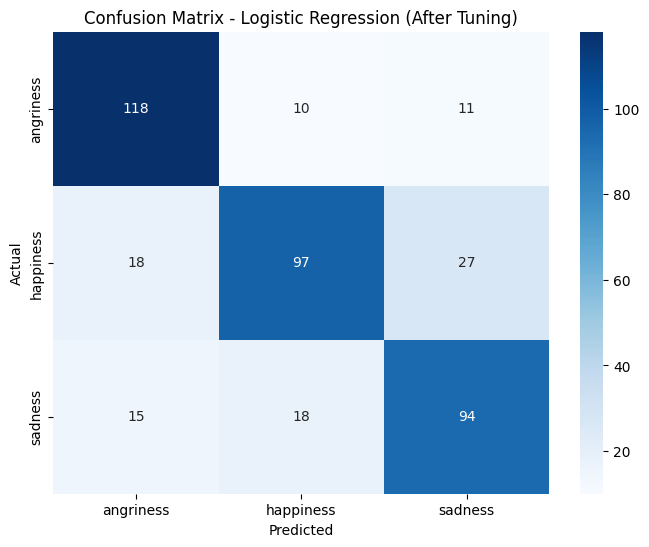

In [57]:
# Confusion Matrix of Logistic Regression After Tuning
# category names from the encoder
category_names = label_encoder.classes_
cm_best_log_reg = confusion_matrix(y_test, y_pred_best_lr)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_best_log_reg, annot=True, fmt='d', cmap='Blues',  xticklabels=category_names, yticklabels=category_names)
plt.title("Confusion Matrix - Logistic Regression (After Tuning)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.savefig(os.path.join(visualization_folder, "confusion_matrix_logistic_regression_after_tuning.png"))
plt.show()

In [58]:
# Updating score card for Logistic Regression After Tuning
update_score_card(y_test, y_pred_best_lr, "Best Tuned Logistic Regression")

### 2. Support Vector Classifier (SVC)
A powerful algorithm for classification tasks with a clear decision boundary. Effective in high-dimensional spaces. Works well with sparse datasets (like TF-IDF vectors).

In [59]:
# Initializing the SVC model
svc = SVC(kernel='linear')

# Fitting the model on train data
svc.fit(X_train_tfidf, y_train)

# Predicting on test data
y_pred_svc = svc.predict(X_test_tfidf)

In [60]:
# Using accuracy_score() for checking the accuracy on the test data
accuracy_score(y_test,y_pred_svc)

0.7573529411764706

In [61]:
# Classification Report of SVC
print("Support Vector Classifier - Classification Report")
print(classification_report(y_test, y_pred_svc))

Support Vector Classifier - Classification Report
              precision    recall  f1-score   support

           0       0.77      0.86      0.81       139
           1       0.76      0.69      0.72       142
           2       0.74      0.72      0.73       127

    accuracy                           0.76       408
   macro avg       0.76      0.76      0.76       408
weighted avg       0.76      0.76      0.76       408



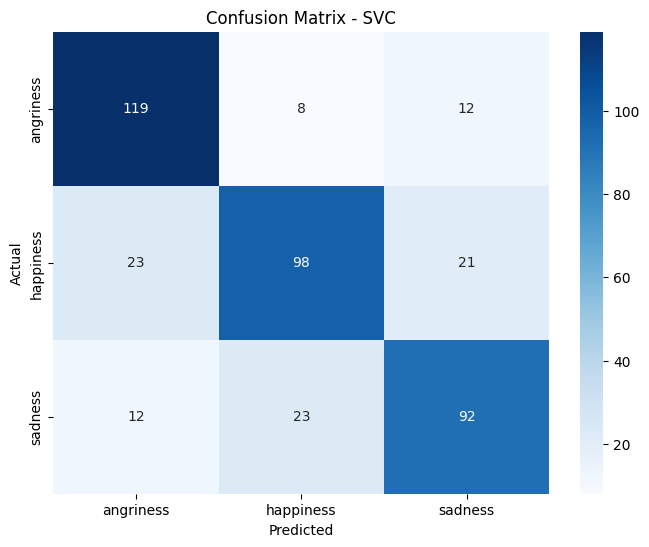

In [62]:
# Confusion Matrix of SVC
# category names from the encoder
category_names = label_encoder.classes_
cm_svc = confusion_matrix(y_test, y_pred_svc)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_svc, annot=True, fmt='d', cmap='Blues', xticklabels=category_names, yticklabels=category_names)
plt.title("Confusion Matrix - SVC")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.savefig(os.path.join(visualization_folder, "confusion_matrix_svc.png"))
plt.show()

In [63]:
# Updating score card for SVC
update_score_card(y_test, y_pred_svc, "Support Vector Classifier")

### Hyperparameter Tuning - Support Vector Classifier

In [64]:
# Parameter grid
param_grid_svc = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': [0.1, 1, 10]}

# Performing Grid Search
grid_svc = GridSearchCV(SVC(), param_grid_svc, cv=5, scoring='accuracy')
grid_svc.fit(X_train_tfidf, y_train)

# Best Parameters
print("Best Parameters for SVC:", grid_svc.best_params_)

# Evaluation of Best Model
best_svc = grid_svc.best_estimator_
y_pred_best_svc = best_svc.predict(X_test_tfidf)

Best Parameters for SVC: {'C': 1, 'gamma': 1, 'kernel': 'rbf'}


In [65]:
# Using accuracy_score() for checking the accuracy on the test data
accuracy_score(y_test,y_pred_best_svc)

0.7867647058823529

In [66]:
# Classification Report of SVC After Tuning
print("SVC (After Tuning) - Classification Report")
print(classification_report(y_test, y_pred_best_svc))

SVC (After Tuning) - Classification Report
              precision    recall  f1-score   support

           0       0.84      0.81      0.82       139
           1       0.71      0.84      0.77       142
           2       0.83      0.71      0.77       127

    accuracy                           0.79       408
   macro avg       0.80      0.78      0.79       408
weighted avg       0.79      0.79      0.79       408



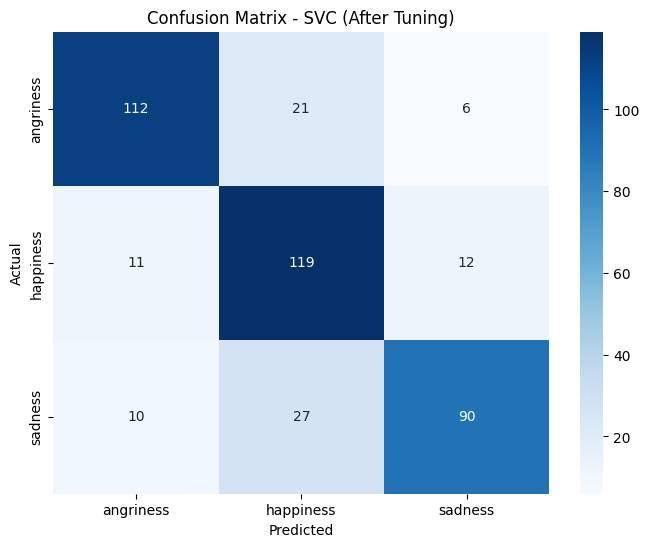

In [67]:
# Confusion Matrix of SVC After Tuning
# category names from the encoder
category_names = label_encoder.classes_
cm_best_svc = confusion_matrix(y_test, y_pred_best_svc)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_best_svc, annot=True, fmt='d', cmap='Blues', xticklabels=category_names, yticklabels=category_names)
plt.title("Confusion Matrix - SVC (After Tuning)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.savefig(os.path.join(visualization_folder, "confusion_matrix_svc_after_tuning.png"))
plt.show()

In [68]:
# Updating score card for SVC After Tuning
update_score_card(y_test, y_pred_best_svc, "Best Tuned Support Vector Classifier")

### 3. Naive Bayes Multinomial Classification
A probabilistic model based on Bayes' theorem.
Simple and fast for text data.
Works well with small datasets.

In [69]:
# Initializing the Naive Bayes
mnb = MultinomialNB()
# Fitting the model on train data
mnb.fit(X_train_tfidf, y_train)
# Predicting on the test data
y_pred_mnb = mnb.predict(X_test_tfidf)

In [70]:
# Using accuracy_score() for checking the accuracy on the test data
accuracy_score(y_test,y_pred_mnb)

0.7279411764705882

In [71]:
# Classification Report of Naive Bayes
print("Naive Bayes - Classification Report")
print(classification_report(y_test, y_pred_mnb))

Naive Bayes - Classification Report
              precision    recall  f1-score   support

           0       0.80      0.82      0.81       139
           1       0.81      0.55      0.66       142
           2       0.62      0.83      0.71       127

    accuracy                           0.73       408
   macro avg       0.74      0.73      0.72       408
weighted avg       0.75      0.73      0.72       408



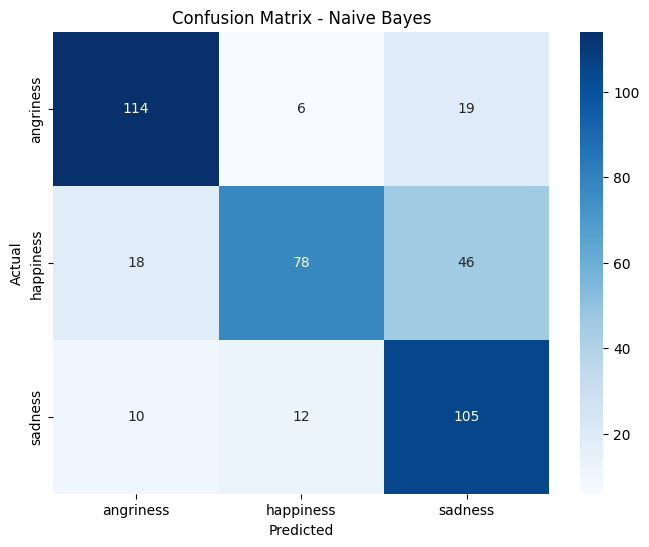

In [72]:
# Confusion Matrix of Naive Bayes
# category names from the encoder
category_names = label_encoder.classes_
cm_nb = confusion_matrix(y_test, y_pred_mnb)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_nb, annot=True, fmt='d', cmap='Blues', xticklabels=category_names, yticklabels=category_names)
plt.title("Confusion Matrix - Naive Bayes")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.savefig(os.path.join(visualization_folder, "confusion_matrix_naive_bayes.png"))
plt.show()

In [73]:
# Updating score card for Naive Bayes
update_score_card(y_test, y_pred_mnb, "Naive Bayes")

### Hyperparameter Tuning For Multinomial Naive Bayes

In [74]:
# Parameter grid
param_grid = {'alpha': [0.01, 0.1, 0.5, 1, 10]}

# Performing grid search
grid_search = GridSearchCV(estimator=mnb, param_grid=param_grid, cv=5, scoring='accuracy', verbose=1)
grid_search.fit(X_train_tfidf, y_train)

# Best parameters and best score
print("Best Parameters:", grid_search.best_params_)

# Predicting on the test set
best_mnb_model = grid_search.best_estimator_
y_pred_best_mnb = best_mnb_model.predict(X_test_tfidf)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Best Parameters: {'alpha': 0.5}


In [75]:
# Using accuracy_score() for checking the accuracy on the test data
print("Best Cross-Validation Accuracy:", grid_search.best_score_)

Best Cross-Validation Accuracy: 0.7320631883079117


In [76]:
# Classification Report of Naive Bayes After Tuning
print("Naive Bayes(After Tuning) - Classification Report")
print(classification_report(y_test, y_pred_best_mnb))

Naive Bayes(After Tuning) - Classification Report
              precision    recall  f1-score   support

           0       0.81      0.82      0.81       139
           1       0.78      0.59      0.67       142
           2       0.65      0.81      0.72       127

    accuracy                           0.74       408
   macro avg       0.74      0.74      0.74       408
weighted avg       0.75      0.74      0.74       408



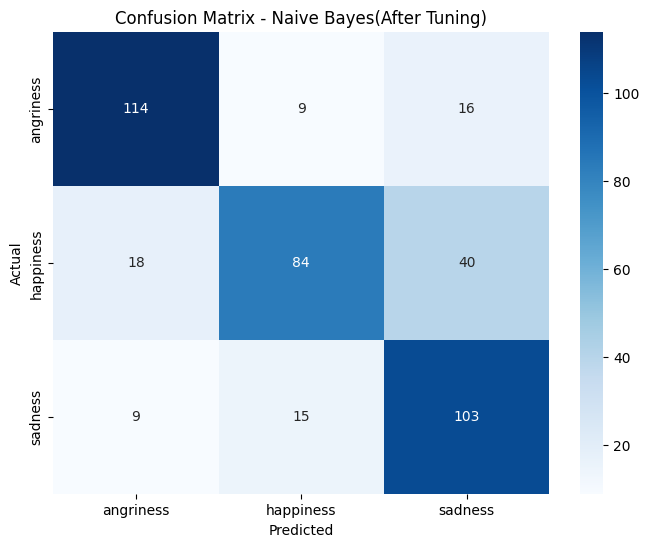

In [77]:
# Confusion Matrix of Naive Bayes After Tuning
# category names from the encoder
category_names = label_encoder.classes_
cm_nb = confusion_matrix(y_test, y_pred_best_mnb)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_nb, annot=True, fmt='d', cmap='Blues', xticklabels=category_names, yticklabels=category_names)
plt.title("Confusion Matrix - Naive Bayes(After Tuning)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.savefig(os.path.join(visualization_folder, "confusion_matrix_naive_bayes_after_tuning.png"))
plt.show()

In [78]:
# Updating score card for Naive Bayes After Tuning
update_score_card(y_test, y_pred_best_mnb, "Best Tuned Naive Bayes")

### 4. K-Nearest Neighbors (KNN)

In [79]:
# Initializing the KNN Model
knn = KNeighborsClassifier(n_neighbors=5)
# Fitting on the train data
knn.fit(X_train_tfidf, y_train)
# Predicting on the test data
y_pred_knn = knn.predict(X_test_tfidf)

In [80]:
# Using accuracy_score() for checking the accuracy on the test data
accuracy_score(y_test,y_pred_knn)

0.6617647058823529

In [81]:
# Classification Report of KNN Model
print("K-Nearest Neighbors - Classification Report")
print(classification_report(y_test, y_pred_knn))

K-Nearest Neighbors - Classification Report
              precision    recall  f1-score   support

           0       0.74      0.68      0.71       139
           1       0.59      0.77      0.66       142
           2       0.71      0.52      0.60       127

    accuracy                           0.66       408
   macro avg       0.68      0.66      0.66       408
weighted avg       0.68      0.66      0.66       408



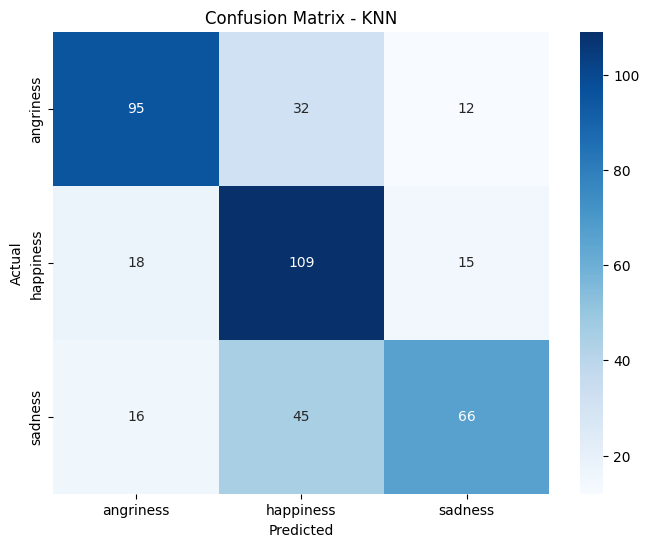

In [82]:
# Confusion Matrix of KNN Model
# category names from the encoder
category_names = label_encoder.classes_
cm_knn = confusion_matrix(y_test, y_pred_knn)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_knn, annot=True, fmt='d', cmap='Blues', xticklabels=category_names, yticklabels=category_names)
plt.title("Confusion Matrix - KNN")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.savefig(os.path.join(visualization_folder, "confusion_matrix_knn.png"))
plt.show()

In [83]:
# Update score card for KNN
update_score_card(y_test, y_pred_knn, "K-Nearest Neighbors")

### Hyperparameter Tuning - KNN Classifier

In [84]:
# Parameter grid
param_grid_knn = {
    'n_neighbors': [3, 5, 7, 9],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']}

# Performing Grid Search
grid_knn = GridSearchCV(KNeighborsClassifier(), param_grid_knn, cv=5, scoring='accuracy')
grid_knn.fit(X_train_tfidf, y_train)

# Best Parameters
print("Best Parameters for KNN:", grid_knn.best_params_)

# Evaluating Best Model
best_knn = grid_knn.best_estimator_
y_pred_best_knn = best_knn.predict(X_test_tfidf)

Best Parameters for KNN: {'metric': 'euclidean', 'n_neighbors': 7, 'weights': 'distance'}


In [85]:
# Using accuracy_score() for checking the accuracy on the test data
accuracy_score(y_test,y_pred_best_knn)

0.7181372549019608

In [86]:
# Classification Report of KNN After Tuning
print("KNN (After Tuning) - Classification Report")
print(classification_report(y_test, y_pred_best_knn))

KNN (After Tuning) - Classification Report
              precision    recall  f1-score   support

           0       0.82      0.72      0.77       139
           1       0.64      0.77      0.70       142
           2       0.73      0.66      0.69       127

    accuracy                           0.72       408
   macro avg       0.73      0.72      0.72       408
weighted avg       0.73      0.72      0.72       408



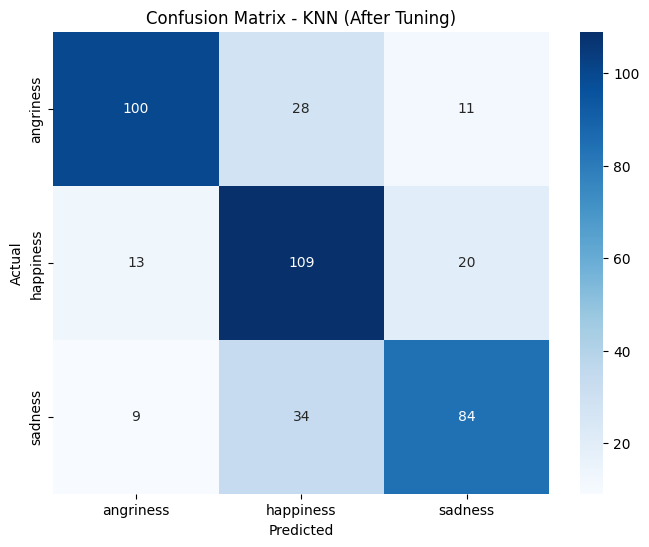

In [87]:
# Confusion Matrix of KNN After Tuning
# category names from the encoder
category_names = label_encoder.classes_
cm_best_knn = confusion_matrix(y_test, y_pred_best_knn)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_best_knn, annot=True, fmt='d', cmap='Blues', xticklabels=category_names, yticklabels=category_names)
plt.title("Confusion Matrix - KNN (After Tuning)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.savefig(os.path.join(visualization_folder, "confusion_matrix_knn_after_tuning.png"))
plt.show()

In [88]:
# Update score card for KNN After Tuning
update_score_card(y_test, y_pred_best_knn, "Best Tuned K-Nearest Neighbors")

### 5. Decision Tree Classifier

In [89]:
# Initializing the Decision Tree Model
dt = DecisionTreeClassifier(random_state=42)
# Fitting the model on the train data
dt.fit(X_train_tfidf, y_train)
# Predicting on the test data
y_pred_dt = dt.predict(X_test_tfidf)

In [90]:
# Using accuracy_score() for checking the accuracy on the test data
accuracy_score(y_test,y_pred_dt)

0.7450980392156863

In [91]:
# Classification Report of Decision Tree
print("Decision Tree Classifier - Classification Report")
print(classification_report(y_test, y_pred_dt))

Decision Tree Classifier - Classification Report
              precision    recall  f1-score   support

           0       0.79      0.80      0.79       139
           1       0.71      0.68      0.70       142
           2       0.74      0.76      0.75       127

    accuracy                           0.75       408
   macro avg       0.74      0.75      0.75       408
weighted avg       0.74      0.75      0.74       408



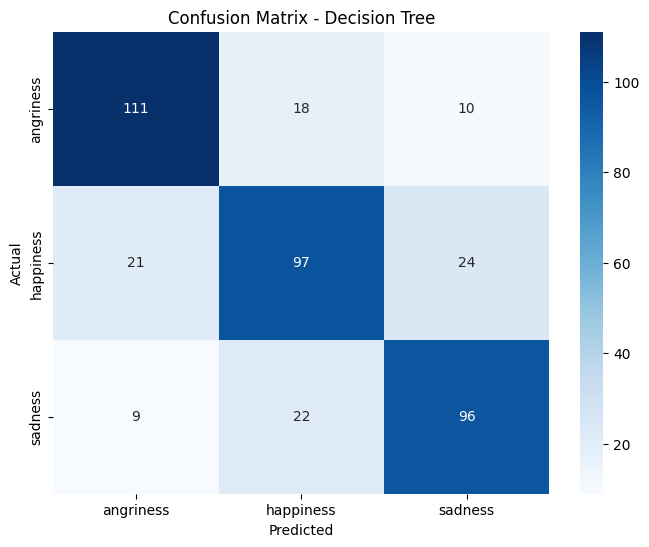

In [92]:
# Confusion Matrix of Decision Tree Model
# category names from the encoder
category_names = label_encoder.classes_
cm_dt = confusion_matrix(y_test, y_pred_dt)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_dt, annot=True, fmt='d', cmap='Blues', xticklabels=category_names, yticklabels=category_names)
plt.title("Confusion Matrix - Decision Tree")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.savefig(os.path.join(visualization_folder, "confusion_matrix_decision_tree.png"))
plt.show()

In [93]:
# Update score card for Decision Tree
update_score_card(y_test, y_pred_dt, "Decision Tree Classifier")

### Hyperparameter Tuning - Decision Tree Classifier

In [94]:
# Parameter grid
param_grid_dt = {
    'max_depth': [5, 10, 15, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]}

# Performing Grid Search
grid_dt = GridSearchCV(DecisionTreeClassifier(random_state=42), param_grid_dt, cv=5, scoring='accuracy')
grid_dt.fit(X_train_tfidf, y_train)

# Best Parameters
print("Best Parameters for Decision Tree:", grid_dt.best_params_)

# Evaluating Best Model on the test data
best_dt = grid_dt.best_estimator_
y_pred_best_dt = best_dt.predict(X_test_tfidf)

Best Parameters for Decision Tree: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2}


In [95]:
# Using accuracy_score() for checking the accuracy on the test data
accuracy_score(y_test,y_pred_best_dt)

0.7450980392156863

In [96]:
# Classification Report of Decision Tree After Tuning
print("Decision Tree (After Tuning) - Classification Report")
print(classification_report(y_test, y_pred_best_dt))

Decision Tree (After Tuning) - Classification Report
              precision    recall  f1-score   support

           0       0.79      0.80      0.79       139
           1       0.71      0.68      0.70       142
           2       0.74      0.76      0.75       127

    accuracy                           0.75       408
   macro avg       0.74      0.75      0.75       408
weighted avg       0.74      0.75      0.74       408



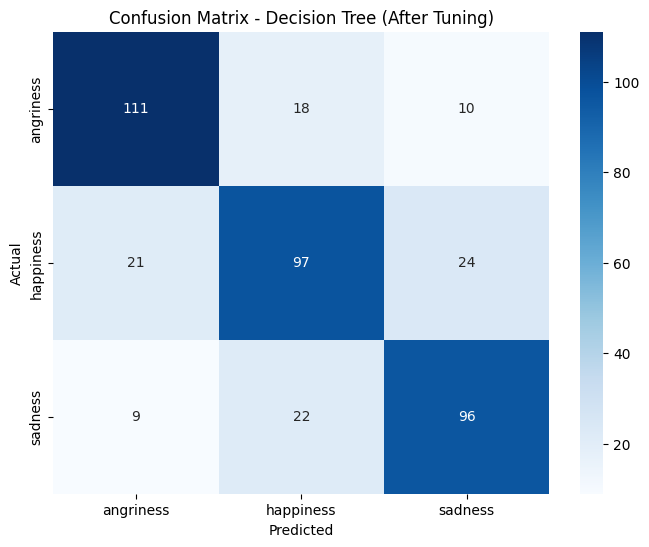

In [97]:
# Confusion Matrix of Decision Tree After Tuning
# category names from the encoder
category_names = label_encoder.classes_
cm_best_dt = confusion_matrix(y_test, y_pred_best_dt)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_best_dt, annot=True, fmt='d', cmap='Blues', xticklabels=category_names, yticklabels=category_names)
plt.title("Confusion Matrix - Decision Tree (After Tuning)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.savefig(os.path.join(visualization_folder, "confusion_matrix_decision_tree_after_tuning.png"))
plt.show()

In [98]:
# Update score card for Decision Tree After Tuning
update_score_card(y_test, y_pred_best_dt, "Best Tuned Decision Tree Classifier")

### 6. Random Forest Classifier

In [99]:
# Initializing the Random Forest Model
rf = RandomForestClassifier(random_state=42)
# Fitting the model on the train data
rf.fit(X_train_tfidf, y_train)
# Predicting on the test data
y_pred_rf = rf.predict(X_test_tfidf)

In [100]:
# Using accuracy_score() for checking the accuracy on the test data
accuracy_score(y_test,y_pred_rf)

0.7745098039215687

In [101]:
# Classification Report of Random Forest Model
print("Random Forest Classifier - Classification Report")
print(classification_report(y_test, y_pred_rf))

Random Forest Classifier - Classification Report
              precision    recall  f1-score   support

           0       0.80      0.79      0.79       139
           1       0.72      0.77      0.75       142
           2       0.82      0.76      0.79       127

    accuracy                           0.77       408
   macro avg       0.78      0.77      0.78       408
weighted avg       0.78      0.77      0.78       408



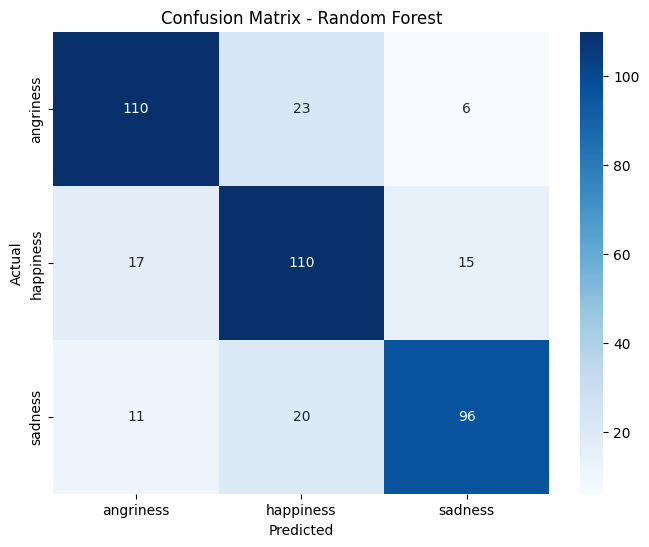

In [102]:
# Confusion Matrix of Random Forest Model
# category names from the encoder
category_names = label_encoder.classes_
cm_rf = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues', xticklabels=category_names, yticklabels=category_names)
plt.title("Confusion Matrix - Random Forest")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.savefig(os.path.join(visualization_folder, "confusion_matrix_random_forest.png"))
plt.show()

In [103]:
# Update score card for Random Forest
update_score_card(y_test, y_pred_rf, "Random Forest Classifier")

### Hyperparameter Tuning - Random Forest Classifier

In [104]:
# Parameter grid
param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]}

# Performing Grid Search
grid_rf = GridSearchCV(RandomForestClassifier(random_state=42), param_grid_rf, cv=5, scoring='accuracy')
grid_rf.fit(X_train_tfidf, y_train)

# Best Parameters
print("Best Parameters for Random Forest:", grid_rf.best_params_)

# Evaluate Best Model
best_rf = grid_rf.best_estimator_
y_pred_best_rf = best_rf.predict(X_test_tfidf)

Best Parameters for Random Forest: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 50}


In [105]:
# Using accuracy_score() for checking the accuracy on the test data
accuracy_score(y_test,y_pred_best_rf)

0.7941176470588235

In [106]:
# Classification Report of Random Forest After Tuning
print("Random Forest (After Tuning) - Classification Report")
print(classification_report(y_test, y_pred_best_rf))

Random Forest (After Tuning) - Classification Report
              precision    recall  f1-score   support

           0       0.85      0.83      0.84       139
           1       0.74      0.75      0.75       142
           2       0.80      0.80      0.80       127

    accuracy                           0.79       408
   macro avg       0.80      0.79      0.79       408
weighted avg       0.79      0.79      0.79       408



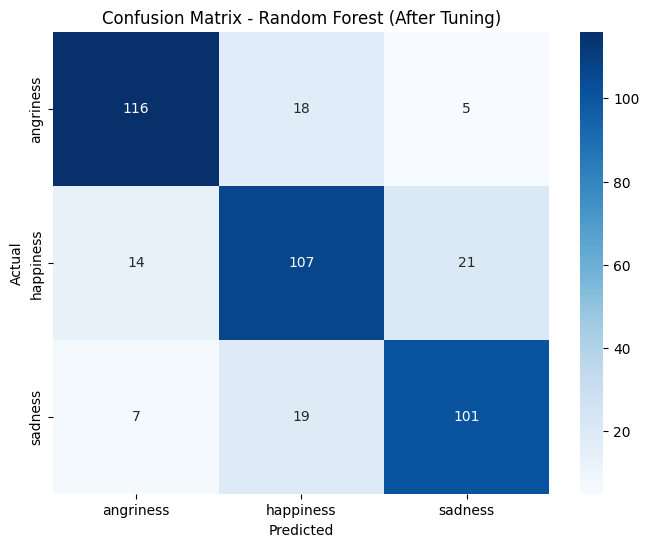

In [107]:
# Confusion Matrix of Random Forest After Tuning
# category names from the encoder
category_names = label_encoder.classes_
cm_best_rf = confusion_matrix(y_test, y_pred_best_rf)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_best_rf, annot=True, fmt='d', cmap='Blues', xticklabels=category_names, yticklabels=category_names)
plt.title("Confusion Matrix - Random Forest (After Tuning)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.savefig(os.path.join(visualization_folder, "confusion_matrix_random_forest_after_tuning.png"))
plt.show()

In [108]:
# Update score card for Random Forest After Tuning
update_score_card(y_test, y_pred_best_rf, "Best Tuned Random Forest Classifier")

### Viewing Score Card and Comparing the accuracy of different models

In [109]:
# Sorting the score_card by Accuracy Score in descending order
score_card_sorted = score_card.sort_values(by="Accuracy Score", ascending=False)
# Displaying the sorted score_card
score_card_sorted

,Model Name,Accuracy Score,Precision Score,Recall Score,F1 Score
11,Best Tuned Random Forest Classifier,0.794118,0.794626,0.794118,0.794344
3,Best Tuned Support Vector Classifier,0.786765,0.794293,0.786765,0.787057
10,Random Forest Classifier,0.774510,0.777191,0.774510,0.775073
1,Best Tuned Logistic Regression,0.757353,0.757975,0.757353,0.756075
2,Support Vector Classifier,0.757353,0.756757,0.757353,0.755733
0,Logistic Regression,0.754902,0.754120,0.754902,0.754117
8,Decision Tree Classifier,0.745098,0.744486,0.745098,0.744669
9,Best Tuned Decision Tree Classifier,0.745098,0.744486,0.745098,0.744669
5,Best Tuned Naive Bayes,0.737745,0.747789,0.737745,0.735503
4,Naive Bayes,0.727941,0.748548,0.727941,0.724648


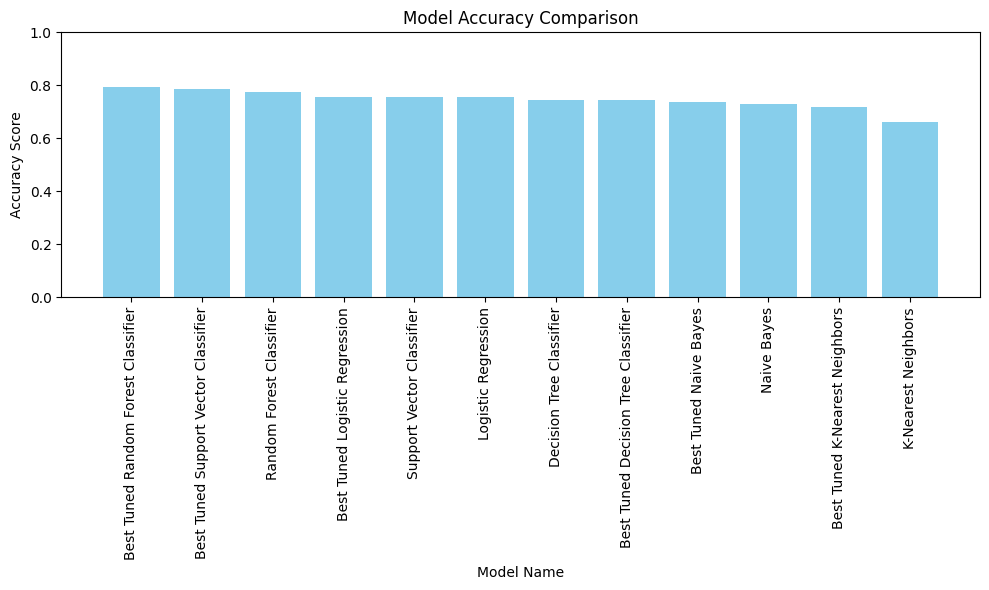

In [110]:
# Visualizing the results
plt.figure(figsize=(10, 6))
plt.bar(score_card_sorted['Model Name'], score_card_sorted['Accuracy Score'], color='skyblue')
plt.title("Model Accuracy Comparison")
plt.xlabel("Model Name")
plt.ylabel("Accuracy Score")
plt.xticks(rotation=90)
plt.ylim(0, 1)  # Accuracy ranges between 0 and 1
plt.tight_layout()
plt.savefig(os.path.join(visualization_folder, "model_accuracy_comparison.png"))
plt.show()

## Observations:
- As we can see from the above bar plot, none of these models are giving an accuracy above 85%. The accuracy not crossing 80% can be attributed to multiple factors, ranging from dataset limitations to model and feature engineering issues.

- One of the reason, I observed in this dataset that may be affecting the accuracy is **Limited Data**. The dataset size is relatively small (1631 training examples), which might not be sufficient for complex NLP tasks.

- Solution for this is augmenting the data by generating synthetic samples or leveraging pre-trained models. Using text augmentation techniques such as synonym replacement, back-translation, or random word insertion to increase dataset size.

## Data Augmentation for Textual Data
#### **What is Data Augmentation?**
Data augmentation involves creating additional training data by modifying or expanding the original data. It helps improve model performance by increasing dataset diversity without requiring manual labeling of more data. This is especially useful when we have a small dataset.

#### **Use of Data Augmentation for Text:**
- Increase Dataset Size: Helps reduce overfitting by creating variations of the existing text.
- Improve Model Robustness: Makes the model less sensitive to small changes in wording or phrasing.
- Handle Class Imbalance: Augment specific classes to balance the dataset.

#### **Techniques for Text Data Augmentation:**
1. Synonym Replacement: Replace words with their synonyms using a thesaurus or libraries like WordNet.
2. Random Insertion: Insert random words or synonyms at random positions in the text.
3. Random Deletion: Randomly remove words from the text with a certain probability.
4. Back Translation: Translate the text to another language and then back to the original language to generate paraphrased data.
5. Token Shuffling: Randomly shuffle the words in the text while keeping the context intact.
6. Paraphrasing: Use pre-trained models like Pegasus or T5 to generate paraphrased sentences.

In [111]:
# Now, I will concat the 3 seperate dataframes of angriness, happiness and sadness into a single data frame as done before
df = pd.concat([angry_df, happy_df, sad_df], ignore_index=True)
df.head()  # Glimpse of the final data

,content,intensity
0,"Sometimes I’m not angry, I’m hurt and there’s ...",angriness
1,Not available for busy people☺,angriness
2,I do not exist to impress the world. I exist t...,angriness
3,Everything is getting expensive except some pe...,angriness
4,My phone screen is brighter than my future 🙁,angriness


### Various Functions of Data Augmentation

In [112]:
# 1. Function to fetch synonyms
def fetch_synonyms(word):
    """
    Fetches a list of synonyms for a given word using the WordNet database.

    Parameters:
    - word: The input word for which synonyms are fetched.

    Returns:
    - A list of unique synonyms for the word or an empty list if no synonyms are found.
    """
    synonym_sets = wordnet.synsets(word)
    if not synonym_sets:
        return []  # Return an empty list if no synonyms exist
    return list(set([lemma.name() for synset in synonym_sets for lemma in synset.lemmas()]))

In [113]:
# 2. Function to Replace words with synonyms
def replace_with_synonyms(text, max_replacements):
    """
    Replaces up to 'n' words in a sentence with their synonyms to enhance data variability.

    Parameters:
    - sentence: The input sentence to augment.
    - n: The number of words to replace with synonyms.

    Returns:
    - Augmented sentence with synonyms replacing random words.
    """
    words = text.split()  # Tokenize the sentence into words
    augmented_words = words.copy() # Copy original words for modification

    # Creating a list of words with synonyms available
    replaceable_words = list(set([word for word in words if fetch_synonyms(word)]))
    random.shuffle(replaceable_words) # Randomize the order of replacement

    num_replaced = 0
    for word in replaceable_words:
        synonyms = fetch_synonyms(word)
        if synonyms:
            synonym = random.choice(synonyms)  # Pick a random synonym
            augmented_words = [synonym if token == word else token for token in augmented_words]
            num_replaced += 1
        if num_replaced >= max_replacements:   # Stop after replacing 'n' words
            break
    return ' '.join(augmented_words)

In [114]:
# 3. Function to insert random synonyms
def insert_random_synonyms(text, max_insertions):
    """
    Inserts up to 'n' random synonyms into a sentence at random positions.

    Parameters:
    - sentence: The input sentence to augment.
    - n: The number of random insertions to perform.

    Returns:
    - Augmented sentence with synonyms randomly inserted.
    """
    words = text.split()
    augmented_words = words.copy()
    for _ in range(max_insertions):
        if len(words) == 0:
            break         # To avoid inserting into an empty list

        # Getting synonyms for a random word
        synonyms = fetch_synonyms(random.choice(words))
        if synonyms:
            insert_position = random.randint(0, len(augmented_words)) # Random position for insertion
            augmented_words.insert(insert_position, random.choice(synonyms))  # Insert synonym
    return ' '.join(augmented_words)

In [115]:
# 4. Function to swap random words
def swap_random_words(text, max_swaps):
    """
    Swaps up to 'n' pairs of words in a sentence to alter the structure.

    Parameters:
    - sentence: The input sentence to augment.
    - n: The number of swaps to perform.

    Returns:
    - Augmented sentence with swapped word pairs.
    """
    words = text.split()
    augmented_words = words.copy()
    if len(words) < 2:        # Ensure at least 2 words to swap
        return text
    for _ in range(max_swaps):
        idx1, idx2 = random.sample(range(len(words)), 2)   # Randomly select two indices
        augmented_words[idx1], augmented_words[idx2] = augmented_words[idx2], augmented_words[idx1]  # Swap the words
    return ' '.join(augmented_words)

In [116]:
# 5. Function for deleting Random words
def delete_random_words(text, probability=0.3):
    """
    Deletes words from a sentence randomly based on a specified probability.

    Parameters:
    - sentence: The input sentence to augment.
    - p: The probability of deleting each word.

    Returns:
    - Augmented sentence with random deletions.
    """
    words = text.split()
    if len(words) <= 1:
        return text      # Skip deletion for single-word sentences
    augmented_words = [word for word in words if random.uniform(0, 1) > probability]  # Retain words based on probability
    if not augmented_words:
        return words[0]  # Avoid empty sentences by returning the first word
    return ' '.join(augmented_words)

In [117]:
# 6. Function to apply augmentation
def apply_augmentation(text, num_variations=4):
    """
    Applies various data augmentation techniques to generate multiple versions of a given sentence.

    Parameters:
    - sentence: The input sentence to augment.
    - num_aug: Number of augmented sentences to generate (default is 4).

    Returns:
    - A list of augmented sentences.
    """
    augmented_sentences = []
    augmented_sentences.append(replace_with_synonyms(text, max_replacements=2))  # Replace two words with synonyms
    augmented_sentences.append(insert_random_synonyms(text, max_insertions=2))   # Insert two synonyms at random positions
    augmented_sentences.append(swap_random_words(text, max_swaps=2))     # Swap two words randomly
    augmented_sentences.append(delete_random_words(text, probability=0.3))  # Randomly delete words with 30% probability

    return augmented_sentences

Applying the augmented functions that are defined above on the final df.

In [118]:
# Initializing empty lists to store augmented texts and labels
augmented_texts = []
augmented_labels = []

# Iterating through each row of the DataFrame
for index, row in df.iterrows():
    # Extracting the texts (content) and the corresponding label (intensity) from the row
    original_text = row['content']
    label = row['intensity']

    # Generating augmented sentences for the current sentence using the apply_augmentation function
    # 'num_variations=4' specifies the number of augmented sentences to generate
    augmented_sentences = apply_augmentation(original_text, num_variations=4)

    # Appending the original texts and its label to the augmented lists
    augmented_texts.append(original_text)
    augmented_labels.append(label)

    # Extending the augmented sentences list with the newly generated augmented sentences
    # Extending the augmented labels list by duplicating the original label for each augmented sentence
    augmented_texts.extend(augmented_sentences)
    augmented_labels.extend([label] * len(augmented_sentences))

# Creating a new DataFrame containing the augmented texts and their labels
augmented_dataset = pd.DataFrame({
    'content': augmented_texts,     # The augmented texts
    'intensity': augmented_labels   # The corresponding labels for the augmented sentences
})

# Combining the original DataFrame with the augmented DataFrame to create a final DataFrame
# This includes both the original data and the augmented data (optional step)
final_df = pd.concat([df, augmented_dataset]).reset_index(drop=True)

# Print a message indicating that the augmentation is complete and the dataset has been saved
print("Augmentation complete. Saved to 'augmented_dataset.csv'")

Augmentation complete. Saved to 'augmented_dataset.csv'


In [119]:
# Taking a glimpse on augmented dataset.
augmented_dataset.head()

,content,intensity
0,"Sometimes I’m not angry, I’m hurt and there’s ...",angriness
1,"Sometimes I’m not angry, I’m anguish and there...",angriness
2,"Sometimes I’m sometimes not angry, I’m hurt an...",angriness
3,"Sometimes I’m I’m angry, a hurt and there’s no...",angriness
4,"not angry, hurt and there’s difference.",angriness


In [120]:
# Checking the shape of the augmented dataset.
print("Shape of the augmented dataset is, ",augmented_dataset.shape)

Shape of the augmented dataset is,  (10195, 2)


In [121]:
# Checking the shape of the final dataset.
print("Shape of the final dataset after augmentation is, ",final_df.shape)

Shape of the final dataset after augmentation is,  (12234, 2)


In [122]:
# Checking the final dataset
final_df.sample(10)

,content,intensity
8785,We are shape and fashioned by those we love.,happiness
2604,Never give up on something you love,angriness
10866,Nothing hurts more than realizing he was every...,sadness
509,1.2 Top Anger Status For Girls,angriness
3747,For every minute you remain of of give up sixt...,angriness
9047,In you love H've Found friend. i of my life an...,happiness
4324,Some people need to open their small minds ins...,angriness
9061,Never hurt people who love you a World_Health_...,sadness
5321,Isn’t it funny how people think you won’t find...,angriness
4215,see_red at lies lasts forever. see_red at trut...,angriness


In [123]:
# Saving the dataset as csv file before the preprocessing
# File path where we want to save the file
file_path = os.path.join("/content/drive/MyDrive/Upgrad_bootcamp/Final Capstone/Intensity_Analysis_Project/Data_Sets/Processed_data", "final_dataset.csv")

# Saving the df dataframe as a csv file
final_df.to_csv(file_path, index=False)  # Set index=False to avoid saving the DataFrame index

## Exploratory Data Analysis and Feature Engineering On final_df

In [124]:
# Analyzing the information of final_df after augmentation
final_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12234 entries, 0 to 12233
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   content    12234 non-null  object
 1   intensity  12234 non-null  object
dtypes: object(2)
memory usage: 191.3+ KB


In [125]:
# Checking for missing values
final_df.isnull().sum()

,0
content,0
intensity,0


In [126]:
# File to save the visualizations of the data after the augmentation in a seperate folder for future references.
visualization_after_augmentation_folder = "/content/drive/MyDrive/Upgrad_bootcamp/Final Capstone/Intensity_Analysis_Project/Visualizations/Visuals_After_Augmentation"

### Analyzing the Target Column (intensity) After Augmentation
#### Class Distribution

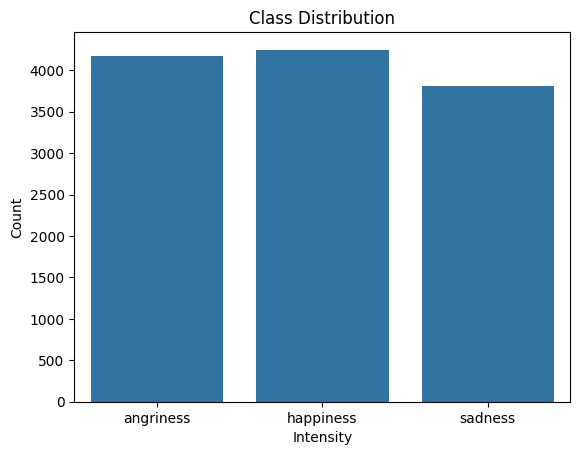

intensity
happiness    4248
angriness    4176
sadness      3810
Name: count, dtype: int64


In [127]:
# Class distribution visualization after augmentation
sns.countplot(data=final_df, x='intensity')
plt.title("Class Distribution")
plt.xlabel("Intensity")
plt.ylabel("Count")
plt.savefig(os.path.join(visualization_after_augmentation_folder, "class distribution visualization.png"))
plt.show()

# Numeric summary of class distribution
print(final_df['intensity'].value_counts())

### Analyzing the Text Column (content) After Augmentation
#### Basic Statistics of Text

In [128]:
# Adding a column for text length
final_df['text_length'] = final_df['content'].apply(lambda x: len(x.split()))

# Summary statistics for text length
print(final_df['text_length'].describe())

count    12234.000000
mean       216.918015
std        579.558221
min          1.000000
25%         10.000000
50%         13.000000
75%         19.000000
max       2167.000000
Name: text_length, dtype: float64


In [129]:
final_df.sample(5)

,content,intensity,text_length
2050,I do non exist to impress the world. I exist t...,angriness,22
7025,felicity bear to be produced to be consumed.,happiness,8
4837,If you’re face! to talk about smile behind my ...,angriness,17
2099,Life is too short don’t waste it by reading my...,angriness,12
11691,"['You Hurt Me But I Still Love You.', 'True Lo...",sadness,2167


### Text Length Per Category After Augmentation

intensity
angriness    216.0
happiness     13.0
sadness      445.0
Name: text_length, dtype: float64


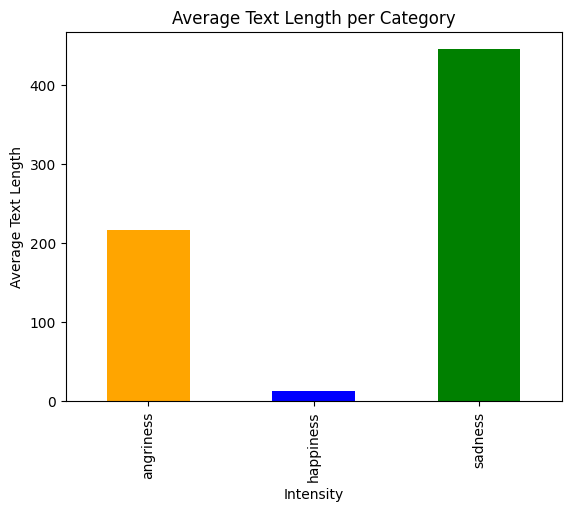

In [130]:
# Group by category and calculating average text length
avg_length_per_category = final_df.groupby('intensity')['text_length'].mean()
print(round(avg_length_per_category))
# Bar plot for average text length by category
avg_length_per_category.plot(kind='bar', color=['orange', 'blue', 'green'])
plt.title("Average Text Length per Category")
plt.xlabel("Intensity")
plt.ylabel("Average Text Length")
plt.savefig(os.path.join(visualization_after_augmentation_folder, "average_text_length_per_category.png"))
plt.show()

Number of words in the content of different intensties varies as shown above. Texts belongs to happiness are of less words compared to angriness comapred to sadness.

## Data Preprocessing After Augmentation:
### Working on content Column:

In [131]:
# Initializing NLTK tools
lemmatizer = WordNetLemmatizer()
stop_words = nltk.corpus.stopwords.words('english')
# removing certain words in the stopwords, so that meaning of the sentence doesn't change
stop_words.remove('no')
stop_words.remove('not')
stop_words.remove('but')

In [132]:
# Function to clean description
def clean_content(text):
    # Convert to lowercase
    text = text.lower()
    # Remove special characters, punctuation, and numbers
    text = re.sub(r'[^a-z\s]', '', text)
    # Tokenize and remove stopwords
    words = text.split()
    words = [word for word in words if word not in stop_words]
    # Lemmatize each word
    words = [lemmatizer.lemmatize(word) for word in words]
    # Join back into a single string
    return ' '.join(words)

In [133]:
# Applying the preprocess_text function on the content column
final_df['cleaned_content'] = final_df['content'].apply(clean_content)

In [134]:
# Adding the cleaned_length column based on the cleaned content
final_df['cleaned_text_length'] = final_df['cleaned_content'].apply(lambda text: len(text.split()))

In [135]:
# Checking the dataframe after preprocessing
final_df.head()

,content,intensity,text_length,cleaned_content,cleaned_text_length
0,"Sometimes I’m not angry, I’m hurt and there’s ...",angriness,11,sometimes im not angry im hurt there big diffe...,9
1,Not available for busy people☺,angriness,5,not available busy people,4
2,I do not exist to impress the world. I exist t...,angriness,22,not exist impress world exist live life way ma...,10
3,Everything is getting expensive except some pe...,angriness,11,everything getting expensive except people get...,7
4,My phone screen is brighter than my future 🙁,angriness,9,phone screen brighter future,4


**Plotting the distribution based on the length of the reviews for each intensity after cleaning and preprocessing**

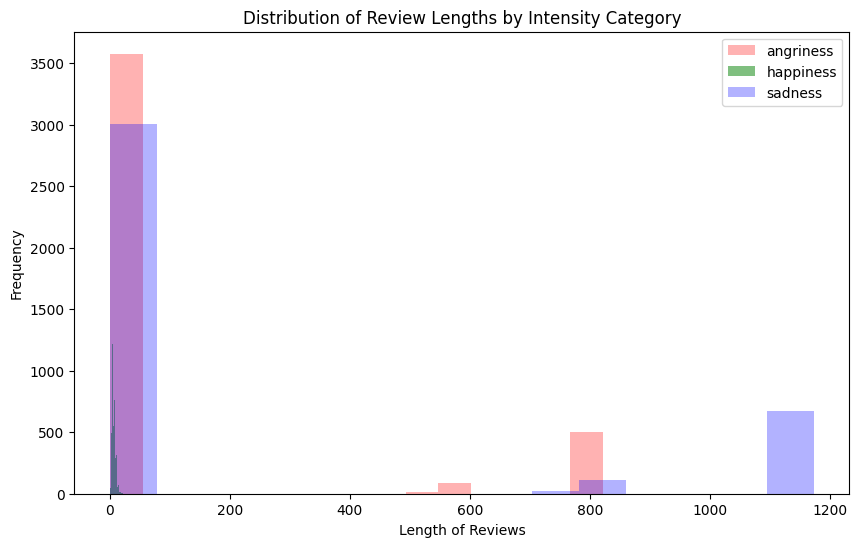

In [136]:
# Plotting histograms for word length by intensity category
plt.figure(figsize=(10, 6))
final_df[final_df['intensity'] == 'angriness']['cleaned_text_length'].plot.hist(bins=15, alpha=0.3, label="angriness", color='red')
final_df[final_df['intensity'] == 'happiness']['cleaned_text_length'].plot.hist(bins=15, alpha=0.5, label="happiness", color='green')
final_df[final_df['intensity'] == 'sadness']['cleaned_text_length'].plot.hist(bins=15, alpha=0.3, label="sadness", color='blue')
plt.xlabel("Length of Reviews")
plt.ylabel("Frequency")
plt.title("Distribution of Review Lengths by Intensity Category")
plt.legend()
plt.savefig(os.path.join(visualization_after_augmentation_folder, "distribution_of_review_lengths_by_intensity_category.png"))
plt.show()

As we can see the word count is reduced after preprocessing.

### Changes in Text Characteristics
Examining how preprocessing impacted specific characteristics like unique words and stopword removal.

In [137]:
# Calculate unique word count before and after cleaning
original_unique_words = set(' '.join(final_df['content']).split())
cleaned_unique_words = set(' '.join(final_df['cleaned_content']).split())

print("Number of unique words in original content:", len(original_unique_words))
print("Number of unique words in cleaned content:", len(cleaned_unique_words))
print("Reduction in unique words after cleaning:", len(original_unique_words) - len(cleaned_unique_words))

Number of unique words in original content: 7016
Number of unique words in cleaned content: 4028
Reduction in unique words after cleaning: 2988


From the above values, we can observe that the unique words count reduced from 6992 to 4004 after preprcessing. It's almost 43% reduction.

### Top Words by Frequency
Identifying the most common words in the cleaned text.

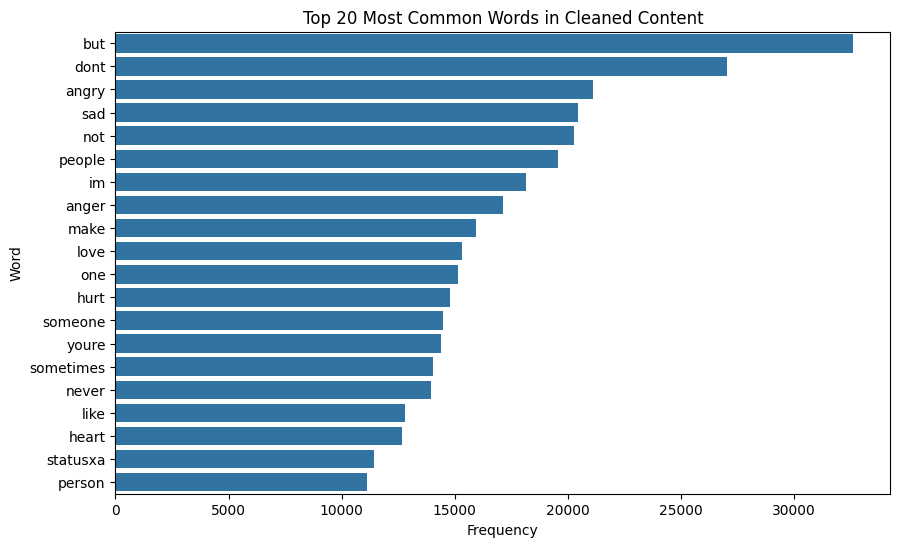

In [138]:
# Flattening all words into a single list
all_words = ' '.join(final_df['cleaned_content']).split()
# Count of word frequencies
word_counts = Counter(all_words)
most_common_words = word_counts.most_common(20)
# Converting to a DataFrame for visualization
word_freq_df = pd.DataFrame(most_common_words, columns=['Word', 'Frequency'])
# Plotting the most common words
plt.figure(figsize=(10, 6))
sns.barplot(data=word_freq_df, x='Frequency', y='Word')
plt.title('Top 20 Most Common Words in Cleaned Content')
plt.xlabel('Frequency')
plt.ylabel('Word')
plt.savefig(os.path.join(visualization_after_augmentation_folder, "Top-20_most_common_words.png"))
plt.show()

From the above bar chart, we can see the top 20 most common words in cleaned content against their frequency.

## Splitting the Data into Train and Test After Augmentation

In [139]:
# Encoding target labels (intensity categories)
label_encoder = LabelEncoder()
final_df['intensity_encoded'] = label_encoder.fit_transform(final_df['intensity'])

In [140]:
# Separating features and target
X = final_df['cleaned_content']
y = final_df['intensity_encoded']

In [141]:
# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [142]:
X_train

,cleaned_content
9826,jazz hate jealous know not single
11035,dont upkeep long know personify nobody
1228,laughing kissing mean completely comfortable
2187,disturb disturbed dont enough already
9875,need something hold deoxyadenosinemonophosphat...
...,...
1021,useful happy else incidental
2810,anger poison must purge mind operatingroom els...
4021,follow center heart see land
3016,hating wont make pretty anger one letter short...


In [143]:
# Checking the shapes of the resulting splits
print("Training feature set size:", X_train.shape)
print("Testing feature set size:", X_test.shape)
print("Training target set size:", y_train.shape)
print("Testing target set size:", y_test.shape)

Training feature set size: (9787,)
Testing feature set size: (2447,)
Training target set size: (9787,)
Testing target set size: (2447,)


In [144]:
print(y_train.value_counts())
print(y_test.value_counts())

intensity_encoded
1    3398
0    3341
2    3048
Name: count, dtype: int64
intensity_encoded
1    850
0    835
2    762
Name: count, dtype: int64


## Vectorization After Augmentation:
Here I am applying TF-IDF Vectorizer.

TF-IDF Vectorization to convert text data into numerical feature vectors, which can be used as input for machine learning models.

The TF-IDF Vectorizer (Term Frequency-Inverse Document Frequency) is a popular technique in Natural Language Processing (NLP) used to convert text into numerical features based on the importance of words in a document relative to a collection of documents (corpus).

In [145]:
# Initializing TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')

In [146]:
# Fitting on training data and transform both train and test sets
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

In [147]:
# Defining the folder where models will be saved
folder = "/content/drive/MyDrive/Upgrad_bootcamp/Final Capstone/Intensity_Analysis_Project/Models"
# Assuming `tfidf_vectorizer` is your TF-IDF instance used for training
joblib.dump(tfidf_vectorizer, os.path.join(folder,'tfidf_vectorizer.pkl'))

['/content/drive/MyDrive/Upgrad_bootcamp/Final Capstone/Intensity_Analysis_Project/Models/tfidf_vectorizer.pkl']

In [148]:
# Displaying the shapes of the resulting vectorized data
print("TF-IDF training set shape:", X_train_tfidf.shape)
print("TF-IDF testing set shape:", X_test_tfidf.shape)

TF-IDF training set shape: (9787, 3647)
TF-IDF testing set shape: (2447, 3647)


## Model Selection & Model Building After Augmentation on final_df:
For text classification projects, common options include:
1. Logistic Regression
2. Support Vector Machines (SVM)
3. Naive Bayes
4. K Neighbors Classifier
5. Decision Tree Classifier
6. Random Forest Classifier

### Evaluation Metrics:
Accuracy, precision, recall, F1 score, classification report.
Confusion matrix with category names.

### Hyperparameter Tuning:
Optimizing models using grid search for parameters like learning rate, regularization, and depth.

Before continuing with models, let's create a dataframe as the score-card for comparing the scores of different models after building and hypertuning after augmentation.

In [149]:
# Initializing the final_score_card with specified column names and data types
final_score_card = pd.DataFrame(columns=['Model Name', 'Accuracy Score', 'Precision Score', 'Recall Score', 'F1 Score'])

# Function to update the final_score_card
def update_final_score_card(y_test, y_pred, model_name):
    """
    Updates the score_card DataFrame with performance metrics for a given model.
    """
    global final_score_card

    # Creating a new row with the metrics
    new_row = pd.DataFrame([{
        'Model Name': model_name,
        'Accuracy Score': accuracy_score(y_test, y_pred),
        'Precision Score': precision_score(y_test, y_pred, average="weighted"),
        'Recall Score': recall_score(y_test, y_pred, average="weighted"),
        'F1 Score': f1_score(y_test, y_pred, average="weighted")
    }])

    # Appending the new row to the final_score_card
    final_score_card = pd.concat([final_score_card, new_row], ignore_index=True)

### 1. Logistic Regression Model
A simple and efficient model for text classification.
Works well with high-dimensional data like text after TF-IDF or Count Vectorization.
Fast to train and interpret.

In [150]:
# Initializing the logistic regression model
alr = LogisticRegression(max_iter=1000)
# Fitting the model on the training data
alr.fit(X_train_tfidf, y_train)
# Predicting on test data
y_pred_lr = alr.predict(X_test_tfidf)

In [151]:
# Using accuracy_score() for checking the accuracy on the test data
accuracy_score(y_test,y_pred_lr)

0.9162239476910503

In [152]:
# Classification Report of Logistic Regression
print("Logistic Regression - Classification Report")
print(classification_report(y_test, y_pred_lr))

Logistic Regression - Classification Report
              precision    recall  f1-score   support

           0       0.93      0.94      0.94       835
           1       0.90      0.93      0.92       850
           2       0.91      0.88      0.89       762

    accuracy                           0.92      2447
   macro avg       0.92      0.91      0.92      2447
weighted avg       0.92      0.92      0.92      2447



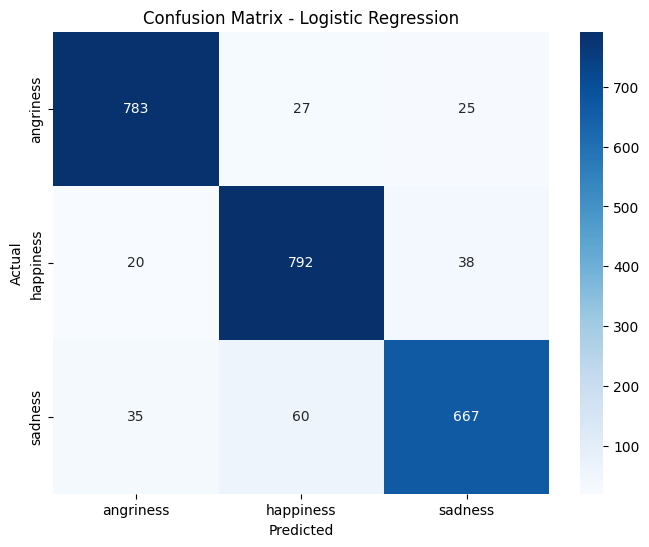

In [153]:
# Confusion Matrix of Logistic Regression
# category names from the encoder
category_names = label_encoder.classes_
cm_lr = confusion_matrix(y_test, y_pred_lr)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Blues', xticklabels=category_names, yticklabels=category_names)
plt.title("Confusion Matrix - Logistic Regression")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.savefig(os.path.join(visualization_after_augmentation_folder, "confusion_matrix_logistic_regression.png"))
plt.show()

In [154]:
# Update score card for Logistic Regression
update_final_score_card(y_test, y_pred_lr, "Logistic Regression")

<ipython-input-149-a3e00cf84689>:21: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  final_score_card = pd.concat([final_score_card, new_row], ignore_index=True)


### Hyperparameter Tuning - Logistic Regression

In [155]:
# Parameter grid
param_grid_log_reg = {
    'C': [0.01, 0.1, 1, 10],
    'solver': ['liblinear', 'lbfgs']}

# Performing Grid Search
grid_log_reg = GridSearchCV(LogisticRegression(max_iter=1000), param_grid_log_reg, cv=5, scoring='accuracy')
grid_log_reg.fit(X_train_tfidf, y_train)

# Best Parameters
print("Best Parameters for Logistic Regression:", grid_log_reg.best_params_)

# Evaluation of Best Model
best_alog_reg = grid_log_reg.best_estimator_
y_pred_best_lr = best_alog_reg.predict(X_test_tfidf)

Best Parameters for Logistic Regression: {'C': 10, 'solver': 'lbfgs'}


In [156]:
# Using accuracy_score() for checking the accuracy on the test data
accuracy_score(y_test,y_pred_best_lr)

0.9378831221904372

In [157]:
# Classification Report of Logistic Regression After Tuning
print("Logistic Regression (After Tuning) - Classification Report")
print(classification_report(y_test, y_pred_best_lr))

Logistic Regression (After Tuning) - Classification Report
              precision    recall  f1-score   support

           0       0.94      0.94      0.94       835
           1       0.93      0.95      0.94       850
           2       0.94      0.92      0.93       762

    accuracy                           0.94      2447
   macro avg       0.94      0.94      0.94      2447
weighted avg       0.94      0.94      0.94      2447



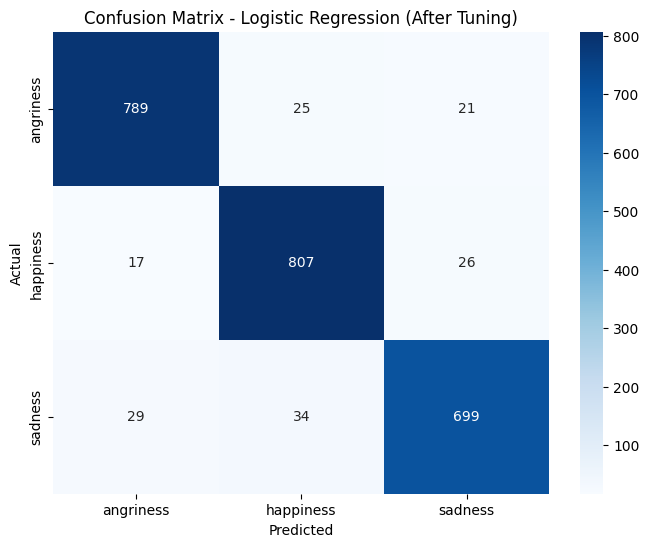

In [158]:
# Confusion Matrix of Logistic Regression After Tuning
# category names from the encoder
category_names = label_encoder.classes_
cm_best_log_reg = confusion_matrix(y_test, y_pred_best_lr)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_best_log_reg, annot=True, fmt='d', cmap='Blues',  xticklabels=category_names, yticklabels=category_names)
plt.title("Confusion Matrix - Logistic Regression (After Tuning)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.savefig(os.path.join(visualization_after_augmentation_folder, "confusion_matrix_logistic_regression_after_tuning.png"))
plt.show()

In [159]:
# Updating score card for Logistic Regression After Tuning
update_final_score_card(y_test, y_pred_best_lr, "Best Tuned Logistic Regression")

### 2. Support Vector Classifier (SVC)
A powerful algorithm for classification tasks with a clear decision boundary. Effective in high-dimensional spaces. Works well with sparse datasets (like TF-IDF vectors).

In [160]:
# Initializing the SVC model
asvc = SVC(kernel='linear')

# Fitting the model on train data
asvc.fit(X_train_tfidf, y_train)

# Predicting on test data
y_pred_svc = asvc.predict(X_test_tfidf)

In [161]:
# Using accuracy_score() for checking the accuracy on the test data
accuracy_score(y_test,y_pred_svc)

0.9256232120964446

In [162]:
# Classification Report of SVC
print("Support Vector Classifier - Classification Report")
print(classification_report(y_test, y_pred_svc))

Support Vector Classifier - Classification Report
              precision    recall  f1-score   support

           0       0.93      0.94      0.94       835
           1       0.93      0.93      0.93       850
           2       0.92      0.90      0.91       762

    accuracy                           0.93      2447
   macro avg       0.93      0.92      0.93      2447
weighted avg       0.93      0.93      0.93      2447



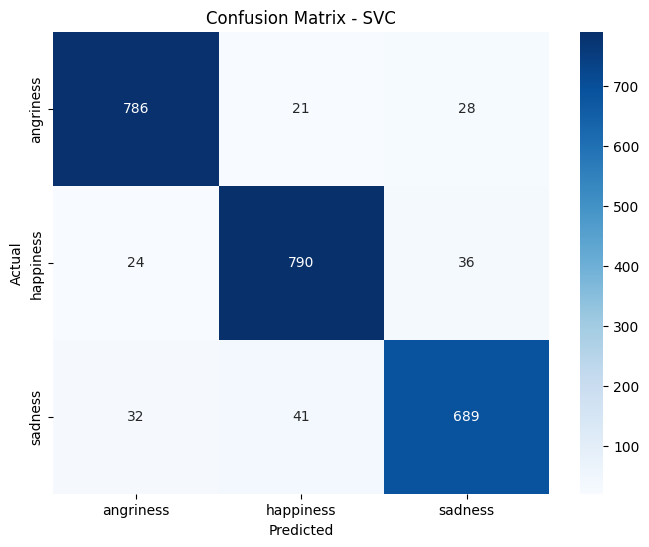

In [163]:
# Confusion Matrix of SVC
# category names from the encoder
category_names = label_encoder.classes_
cm_svc = confusion_matrix(y_test, y_pred_svc)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_svc, annot=True, fmt='d', cmap='Blues', xticklabels=category_names, yticklabels=category_names)
plt.title("Confusion Matrix - SVC")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.savefig(os.path.join(visualization_after_augmentation_folder, "confusion_matrix_svc.png"))
plt.show()

In [164]:
# Updating score card for SVC
update_final_score_card(y_test, y_pred_svc, "Support Vector Classifier")

### Hyperparameter Tuning - Support Vector Classifier

In [165]:
# Parameter grid
param_grid_svc = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': [0.1, 1, 10]}

# Performing Grid Search
grid_svc = GridSearchCV(SVC(), param_grid_svc, cv=5, scoring='accuracy')
grid_svc.fit(X_train_tfidf, y_train)

# Best Parameters
print("Best Parameters for SVC:", grid_svc.best_params_)

# Evaluation of Best Model
best_asvc = grid_svc.best_estimator_
y_pred_best_svc = best_asvc.predict(X_test_tfidf)

Best Parameters for SVC: {'C': 10, 'gamma': 1, 'kernel': 'rbf'}


In [166]:
# Using accuracy_score() for checking the accuracy on the test data
accuracy_score(y_test,y_pred_best_svc)

0.9603596240294238

In [167]:
# Classification Report of SVC After Tuning
print("SVC (After Tuning) - Classification Report")
print(classification_report(y_test, y_pred_best_svc))

SVC (After Tuning) - Classification Report
              precision    recall  f1-score   support

           0       0.96      0.97      0.97       835
           1       0.95      0.96      0.96       850
           2       0.97      0.94      0.96       762

    accuracy                           0.96      2447
   macro avg       0.96      0.96      0.96      2447
weighted avg       0.96      0.96      0.96      2447



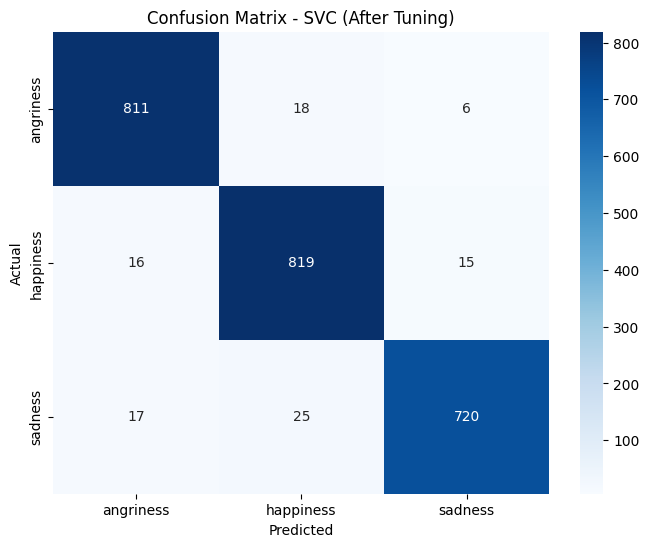

In [168]:
# Confusion Matrix of SVC After Tuning
# category names from the encoder
category_names = label_encoder.classes_
cm_best_svc = confusion_matrix(y_test, y_pred_best_svc)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_best_svc, annot=True, fmt='d', cmap='Blues', xticklabels=category_names, yticklabels=category_names)
plt.title("Confusion Matrix - SVC (After Tuning)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.savefig(os.path.join(visualization_after_augmentation_folder, "confusion_matrix_svc_after_tuning.png"))
plt.show()

In [169]:
# Updating score card for SVC After Tuning
update_final_score_card(y_test, y_pred_best_svc, "Best Tuned Support Vector Classifier")

### 3. Naive Bayes Multinomial Classification
A probabilistic model based on Bayes' theorem. Simple and fast for text data. Works well with small datasets.

In [170]:
# Initializing the Naive Bayes
amnb = MultinomialNB()
# Fitting the model on train data
amnb.fit(X_train_tfidf, y_train)
# Predicting on the test data
y_pred_mnb = amnb.predict(X_test_tfidf)

In [171]:
# Using accuracy_score() for checking the accuracy on the test data
accuracy_score(y_test,y_pred_mnb)

0.8545157335512873

In [172]:
# Classification Report of Naive Bayes
print("Naive Bayes - Classification Report")
print(classification_report(y_test, y_pred_mnb))

Naive Bayes - Classification Report
              precision    recall  f1-score   support

           0       0.88      0.87      0.88       835
           1       0.87      0.84      0.85       850
           2       0.82      0.85      0.83       762

    accuracy                           0.85      2447
   macro avg       0.85      0.85      0.85      2447
weighted avg       0.86      0.85      0.85      2447



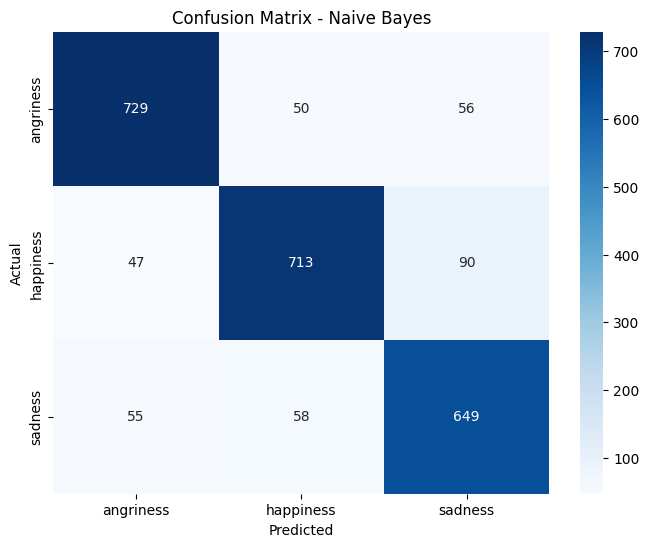

In [173]:
# Confusion Matrix of Naive Bayes
# category names from the encoder
category_names = label_encoder.classes_
cm_nb = confusion_matrix(y_test, y_pred_mnb)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_nb, annot=True, fmt='d', cmap='Blues', xticklabels=category_names, yticklabels=category_names)
plt.title("Confusion Matrix - Naive Bayes")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.savefig(os.path.join(visualization_after_augmentation_folder, "confusion_matrix_naive_bayes.png"))
plt.show()

In [174]:
# Updating score card for Naive Bayes
update_final_score_card(y_test, y_pred_mnb, "Naive Bayes")

### Hyperparameter Tuning For Multinomial Naive Bayes

In [175]:
# Parameter grid
param_grid = {'alpha': [0.01, 0.1, 0.5, 1, 10]}

# Performing grid search
grid_search = GridSearchCV(estimator=mnb, param_grid=param_grid, cv=5, scoring='accuracy', verbose=1)
grid_search.fit(X_train_tfidf, y_train)

# Best parameters and best score
print("Best Parameters:", grid_search.best_params_)

# Predicting on the test set
best_amnb_model = grid_search.best_estimator_
y_pred_best_mnb = best_amnb_model.predict(X_test_tfidf)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Best Parameters: {'alpha': 0.01}


In [176]:
# Using accuracy_score() for checking the accuracy on the test data
print("Best Cross-Validation Accuracy:", grid_search.best_score_)

Best Cross-Validation Accuracy: 0.8664553998819355


In [177]:
# Classification Report of Naive Bayes After Tuning
print("Naive Bayes(After Tuning) - Classification Report")
print(classification_report(y_test, y_pred_best_mnb))

Naive Bayes(After Tuning) - Classification Report
              precision    recall  f1-score   support

           0       0.89      0.88      0.88       835
           1       0.86      0.86      0.86       850
           2       0.83      0.85      0.84       762

    accuracy                           0.86      2447
   macro avg       0.86      0.86      0.86      2447
weighted avg       0.86      0.86      0.86      2447



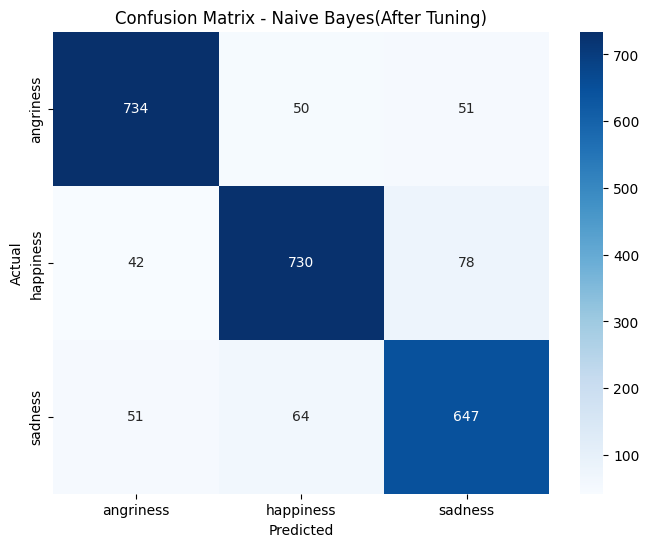

In [178]:
# Confusion Matrix of Naive Bayes After Tuning
# category names from the encoder
category_names = label_encoder.classes_
cm_nb = confusion_matrix(y_test, y_pred_best_mnb)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_nb, annot=True, fmt='d', cmap='Blues', xticklabels=category_names, yticklabels=category_names)
plt.title("Confusion Matrix - Naive Bayes(After Tuning)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.savefig(os.path.join(visualization_after_augmentation_folder, "confusion_matrix_naive_bayes_after_tuning.png"))
plt.show()

In [179]:
# Updating score card for Naive Bayes After Tuning
update_final_score_card(y_test, y_pred_best_mnb, "Best Tuned Naive Bayes")

### 4. K-Nearest Neighbors (KNN)

In [180]:
# Initializing the KNN Model
aknn = KNeighborsClassifier(n_neighbors=5)
# Fitting on the train data
aknn.fit(X_train_tfidf, y_train)
# Predicting on the test data
y_pred_knn = aknn.predict(X_test_tfidf)

In [181]:
# Using accuracy_score() for checking the accuracy on the test data
accuracy_score(y_test,y_pred_knn)

0.9280751941152432

In [182]:
# Classification Report of KNN Model
print("K-Nearest Neighbors - Classification Report")
print(classification_report(y_test, y_pred_knn))

K-Nearest Neighbors - Classification Report
              precision    recall  f1-score   support

           0       0.91      0.95      0.93       835
           1       0.95      0.91      0.93       850
           2       0.92      0.92      0.92       762

    accuracy                           0.93      2447
   macro avg       0.93      0.93      0.93      2447
weighted avg       0.93      0.93      0.93      2447



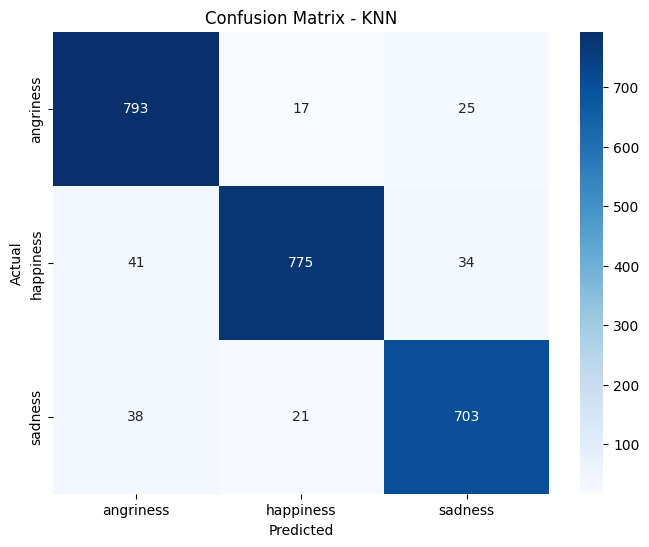

In [183]:
# Confusion Matrix of KNN Model
# category names from the encoder
category_names = label_encoder.classes_
cm_knn = confusion_matrix(y_test, y_pred_knn)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_knn, annot=True, fmt='d', cmap='Blues', xticklabels=category_names, yticklabels=category_names)
plt.title("Confusion Matrix - KNN")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.savefig(os.path.join(visualization_after_augmentation_folder, "confusion_matrix_knn.png"))
plt.show()

In [184]:
# Update score card for KNN
update_final_score_card(y_test, y_pred_knn, "K-Nearest Neighbors")

### Hyperparameter Tuning - KNN Classifier

In [185]:
# Parameter grid
param_grid_knn = {
    'n_neighbors': [3, 5, 7, 9],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']}

# Performing Grid Search
grid_knn = GridSearchCV(KNeighborsClassifier(), param_grid_knn, cv=5, scoring='accuracy')
grid_knn.fit(X_train_tfidf, y_train)

# Best Parameters
print("Best Parameters for KNN:", grid_knn.best_params_)

# Evaluating Best Model
best_aknn = grid_knn.best_estimator_
y_pred_best_knn = best_aknn.predict(X_test_tfidf)

Best Parameters for KNN: {'metric': 'euclidean', 'n_neighbors': 3, 'weights': 'distance'}


In [186]:
# Using accuracy_score() for checking the accuracy on the test data
accuracy_score(y_test,y_pred_best_knn)

0.9587249693502248

In [187]:
# Classification Report of KNN After Tuning
print("KNN (After Tuning) - Classification Report")
print(classification_report(y_test, y_pred_best_knn))

KNN (After Tuning) - Classification Report
              precision    recall  f1-score   support

           0       0.94      0.98      0.96       835
           1       0.97      0.95      0.96       850
           2       0.97      0.94      0.95       762

    accuracy                           0.96      2447
   macro avg       0.96      0.96      0.96      2447
weighted avg       0.96      0.96      0.96      2447



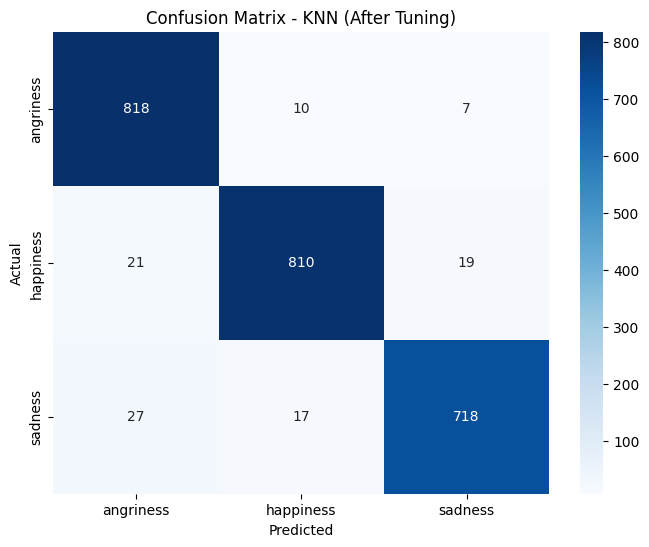

In [188]:
# Confusion Matrix of KNN After Tuning
# category names from the encoder
category_names = label_encoder.classes_
cm_best_knn = confusion_matrix(y_test, y_pred_best_knn)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_best_knn, annot=True, fmt='d', cmap='Blues', xticklabels=category_names, yticklabels=category_names)
plt.title("Confusion Matrix - KNN (After Tuning)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.savefig(os.path.join(visualization_after_augmentation_folder, "confusion_matrix_knn_after_tuning.png"))
plt.show()

In [189]:
# Update score card for KNN After Tuning
update_final_score_card(y_test, y_pred_best_knn, "Best Tuned K-Nearest Neighbors")

### 5. Decision Tree Classifier

In [190]:
# Initializing the Decision Tree Model
adt = DecisionTreeClassifier(random_state=42)
# Fitting the model on the train data
adt.fit(X_train_tfidf, y_train)
# Predicting on the test data
y_pred_dt = adt.predict(X_test_tfidf)

In [191]:
# Using accuracy_score() for checking the accuracy on the test data
accuracy_score(y_test,y_pred_dt)

0.9215365753984471

In [192]:
# Classification Report of Decision Tree
print("Decision Tree Classifier - Classification Report")
print(classification_report(y_test, y_pred_dt))

Decision Tree Classifier - Classification Report
              precision    recall  f1-score   support

           0       0.90      0.96      0.93       835
           1       0.94      0.89      0.92       850
           2       0.93      0.92      0.92       762

    accuracy                           0.92      2447
   macro avg       0.92      0.92      0.92      2447
weighted avg       0.92      0.92      0.92      2447



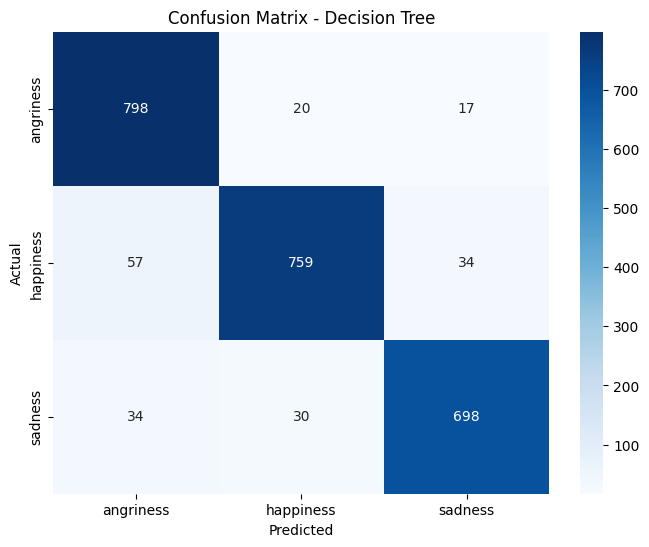

In [193]:
# Confusion Matrix of Decision Tree Model
# category names from the encoder
category_names = label_encoder.classes_
cm_dt = confusion_matrix(y_test, y_pred_dt)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_dt, annot=True, fmt='d', cmap='Blues', xticklabels=category_names, yticklabels=category_names)
plt.title("Confusion Matrix - Decision Tree")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.savefig(os.path.join(visualization_after_augmentation_folder, "confusion_matrix_decision_tree.png"))
plt.show()

In [194]:
# Update score card for Decision Tree
update_final_score_card(y_test, y_pred_dt, "Decision Tree Classifier")

### Hyperparameter Tuning - Decision Tree Classifier

In [195]:
# Parameter grid
param_grid_dt = {
    'max_depth': [5, 10, 15, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]}

# Performing Grid Search
grid_dt = GridSearchCV(DecisionTreeClassifier(random_state=42), param_grid_dt, cv=5, scoring='accuracy')
grid_dt.fit(X_train_tfidf, y_train)

# Best Parameters
print("Best Parameters for Decision Tree:", grid_dt.best_params_)

# Evaluating Best Model on the test data
best_adt = grid_dt.best_estimator_
y_pred_best_dt = best_adt.predict(X_test_tfidf)

Best Parameters for Decision Tree: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2}


In [196]:
# Using accuracy_score() for checking the accuracy on the test data
accuracy_score(y_test,y_pred_best_dt)

0.9215365753984471

In [197]:
# Classification Report of Decision Tree After Tuning
print("Decision Tree (After Tuning) - Classification Report")
print(classification_report(y_test, y_pred_best_dt))

Decision Tree (After Tuning) - Classification Report
              precision    recall  f1-score   support

           0       0.90      0.96      0.93       835
           1       0.94      0.89      0.92       850
           2       0.93      0.92      0.92       762

    accuracy                           0.92      2447
   macro avg       0.92      0.92      0.92      2447
weighted avg       0.92      0.92      0.92      2447



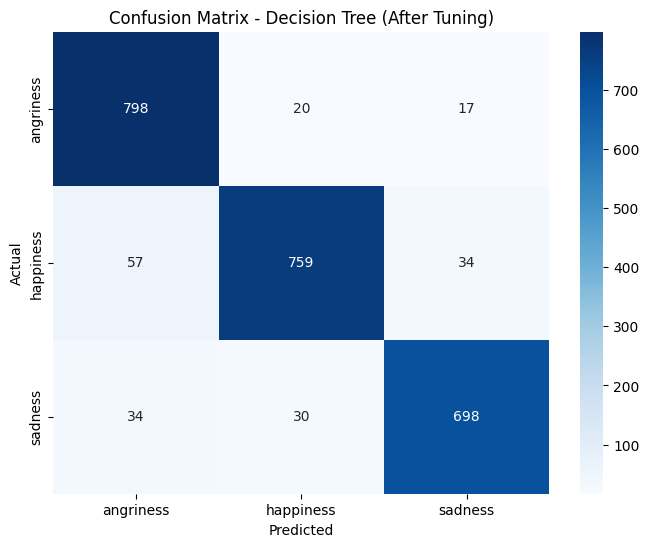

In [198]:
# Confusion Matrix of Decision Tree After Tuning
# category names from the encoder
category_names = label_encoder.classes_
cm_best_dt = confusion_matrix(y_test, y_pred_best_dt)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_best_dt, annot=True, fmt='d', cmap='Blues', xticklabels=category_names, yticklabels=category_names)
plt.title("Confusion Matrix - Decision Tree (After Tuning)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.savefig(os.path.join(visualization_after_augmentation_folder, "confusion_matrix_decision_tree_after_tuning.png"))
plt.show()

In [199]:
# Update score card for Decision Tree After Tuning
update_final_score_card(y_test, y_pred_best_dt, "Best Tuned Decision Tree Classifier")

### 6. Random Forest Classifier

In [200]:
# Initializing the Random Forest Model
arf = RandomForestClassifier(random_state=42)
# Fitting the model on the train data
arf.fit(X_train_tfidf, y_train)
# Predicting on the test data
y_pred_rf = arf.predict(X_test_tfidf)

In [201]:
# Using accuracy_score() for checking the accuracy on the test data
accuracy_score(y_test,y_pred_rf)

0.9574989783408255

In [202]:
# Classification Report of Random Forest Model
print("Random Forest Classifier - Classification Report")
print(classification_report(y_test, y_pred_rf))

Random Forest Classifier - Classification Report
              precision    recall  f1-score   support

           0       0.95      0.98      0.96       835
           1       0.96      0.95      0.95       850
           2       0.97      0.95      0.96       762

    accuracy                           0.96      2447
   macro avg       0.96      0.96      0.96      2447
weighted avg       0.96      0.96      0.96      2447



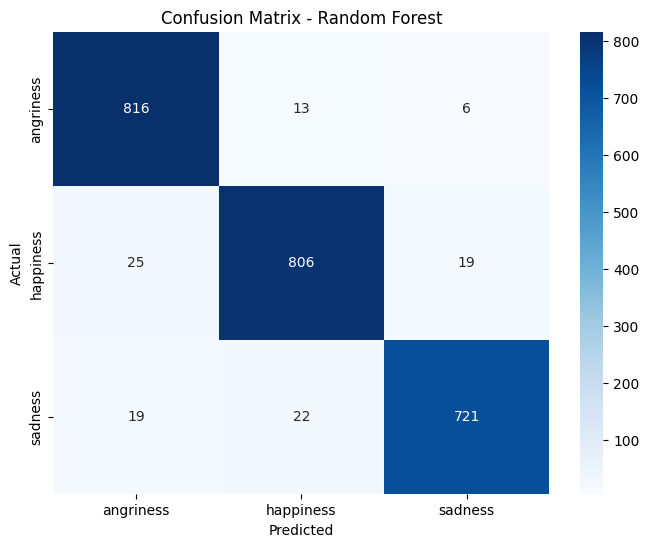

In [203]:
# Confusion Matrix of Random Forest Model
# category names from the encoder
category_names = label_encoder.classes_
cm_rf = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues', xticklabels=category_names, yticklabels=category_names)
plt.title("Confusion Matrix - Random Forest")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.savefig(os.path.join(visualization_after_augmentation_folder, "confusion_matrix_random_forest.png"))
plt.show()

In [204]:
# Update score card for Random Forest
update_final_score_card(y_test, y_pred_rf, "Random Forest Classifier")

### Hyperparameter Tuning - Random Forest Classifier

In [205]:
# Parameter grid
param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]}

# Performing Grid Search
grid_rf = GridSearchCV(RandomForestClassifier(random_state=42), param_grid_rf, cv=5, scoring='accuracy')
grid_rf.fit(X_train_tfidf, y_train)

# Best Parameters
print("Best Parameters for Random Forest:", grid_rf.best_params_)

# Evaluate Best Model
best_arf = grid_rf.best_estimator_
y_pred_best_rf = best_arf.predict(X_test_tfidf)

Best Parameters for Random Forest: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}


In [206]:
# Using accuracy_score() for checking the accuracy on the test data
accuracy_score(y_test,y_pred_best_rf)

0.9574989783408255

In [207]:
# Classification Report of Random Forest After Tuning
print("Random Forest (After Tuning) - Classification Report")
print(classification_report(y_test, y_pred_best_rf))

Random Forest (After Tuning) - Classification Report
              precision    recall  f1-score   support

           0       0.95      0.98      0.96       835
           1       0.96      0.95      0.95       850
           2       0.97      0.95      0.96       762

    accuracy                           0.96      2447
   macro avg       0.96      0.96      0.96      2447
weighted avg       0.96      0.96      0.96      2447



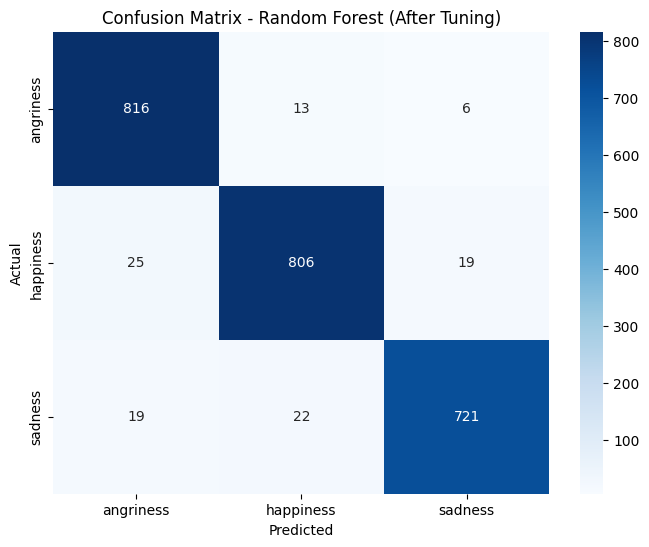

In [208]:
# Confusion Matrix of Random Forest After Tuning
# category names from the encoder
category_names = label_encoder.classes_
cm_best_rf = confusion_matrix(y_test, y_pred_best_rf)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_best_rf, annot=True, fmt='d', cmap='Blues', xticklabels=category_names, yticklabels=category_names)
plt.title("Confusion Matrix - Random Forest (After Tuning)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.savefig(os.path.join(visualization_after_augmentation_folder, "confusion_matrix_random_forest_after_tuning.png"))
plt.show()

In [209]:
# Update score card for Random Forest After Tuning
update_final_score_card(y_test, y_pred_best_rf, "Best Tuned Random Forest Classifier")

As we can observe, after augmentation, there is a significant increase in accuracy. All the supervised models, namely Logistic Regression, Support Vector Machine (SVM) Classifier, KNN Classifier, Decision Tree Classifier, and Random Forest Classifier, achieve an accuracy of over 90%, which is excellent. Any of these models could be effectively used for this use case.

Next, we will explore Deep Learning models to address this NLP problem of intensity analysis, as suggested in the guidelines, and evaluate whether they outperform the traditional models.

## Deep Learning:
Deep learning models can leverage the nuances of the data, potentially uncovering patterns that traditional models might miss.

###Steps to build deep learning models:
- **Preprocess Data:** Ensuring text is tokenized, padded, and vectorized.
- **Define and Train Models:** Using neural architectures like CNN, LSTM, and GRU.
- **Evaluate Models:** Evaluate based on the accuracy of each model.

### Data Preparation for deep learning:

In [210]:
# Parameters
max_words = 5000  # Number of unique words to consider
max_length = 100  # Maximum length of a sequence

In [211]:
# Tokenizing the text
tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)  # This will fit tokenizer on training data
X_train_seq = tokenizer.texts_to_sequences(X_train)  # Converts text to sequences
X_test_seq = tokenizer.texts_to_sequences(X_test)  # Converts test text to sequences

In [212]:
# Padding sequences to ensure consistent input shape
X_train_pad = pad_sequences(X_train_seq, maxlen=max_length, padding='post', truncating='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=max_length, padding='post', truncating='post')

### LSTM - Long Short Term Memory Deep Learning Model
LSTM is a recurrent neural network (RNN) model specialized for sequential data like text. Captures long-term dependencies in text data. Handles large datasets and complex patterns effectively.

In [213]:
# Building LSTM Model
lstm = Sequential([
    Embedding(input_dim=max_words, output_dim=128, input_length=100),
    Bidirectional(LSTM(64, return_sequences=False)),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dense(3, activation='softmax')
])

# Explanation of lstm model building
# 1. Sequential([]): This initializes a stack of layers, where each layer feeds its output to the next layer.
# 2. Embedding Layer - Embedding(input_dim=max_words, output_dim=128, input_length=100):
# - Purpose: Converts integer-encoded words (from tokenization) into dense vector representations.
# - input_dim=max_words: The size of the vocabulary (number of unique words). This limits how many words are considered.
# - output_dim=128: The size of each word vector (embedding dimension).
# - input_length=100: The length of each input sequence (padding ensures uniform length).
# 3. Bidirectional LSTM Layer - Bidirectional(LSTM(64, return_sequences=False)):
# - Bidirectional: Processing input sequences in both forward and backward directions, capturing context from both past and future words.
# - LSTM(64): Adds 64 LSTM units (neurons) to the layer.
# - LSTMs (Long Short-Term Memory) helps in learning long-term dependencies in sequence data.
# - return_sequences=False: Outputs only the final hidden state of the LSTM (not all time-step outputs), suitable for classification tasks.
# 4. Dropout Layer
# - Dropout(0.5): Randomly sets 50% of the layer's neurons to 0 during training to prevent overfitting.
# 5. Dense Layer
# - Dense(64, activation='relu'): Fully connected layer with 64 neurons.
# - Activation Function: ReLU (Rectified Linear Unit) introduces non-linearity to the network, helping to learn complex patterns.
# 6. Output Layer
# - Dense(3, activation='softmax'): Fully connected layer with 3 neurons (corresponding to 3 output classes).
# - Softmax Activation: Converts raw scores into probabilities for each class. Ensures the probabilities sum to 1, making it suitable for multi-class classification.

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [214]:
# Compiling the model
lstm.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [215]:
# Training the model
history = lstm.fit(X_train_pad, y_train, epochs=10, validation_data=(X_test_pad, y_test), batch_size=32)

Epoch 1/10
306/306 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - accuracy: 0.6424 - loss: 0.7609 - val_accuracy: 0.9019 - val_loss: 0.2581
Epoch 2/10
306/306 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.9449 - loss: 0.1685 - val_accuracy: 0.9375 - val_loss: 0.1797
Epoch 3/10
306/306 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.9670 - loss: 0.0954 - val_accuracy: 0.9354 - val_loss: 0.1950
Epoch 4/10
306/306 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.9768 - loss: 0.0706 - val_accuracy: 0.9420 - val_loss: 0.1845
Epoch 5/10
306/306 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.9784 - loss: 0.0603 - val_accuracy: 0.9493 - val_loss: 0.1707
Epoch 6/10
306/306 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.9856 - loss: 0.0447 - val_accuracy: 0.9477 - val_loss: 0.1932
Epoch 7/10
306/306 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.9854 - loss: 0.0399 - val_accuracy: 0.9514 - val_loss: 0.1925
Epoch 8/10
306/306 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.9895 - loss: 0.0336 - val_acc

In [216]:
lstm.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 100, 128)            │         640,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 128)                 │          98,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 3)                   │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,241,803 (8.55 MB)

 Trainable params: 747,267 (2.85 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,494,536 (5.70 MB)

In [217]:
# Evaluating the model
y_pred_prob = lstm.predict(X_test_pad)
y_pred_lstm = np.argmax(y_pred_prob, axis=1)
# Printing the accuracy and classification report of the model
print("\nAccuracy:", accuracy_score(y_test, y_pred_lstm))
print("\nClassification Report:\n", classification_report(y_test, y_pred_lstm))

77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step

Accuracy: 0.9476910502656314

Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.95      0.95       835
           1       0.95      0.95      0.95       850
           2       0.94      0.94      0.94       762

    accuracy                           0.95      2447
   macro avg       0.95      0.95      0.95      2447
weighted avg       0.95      0.95      0.95      2447



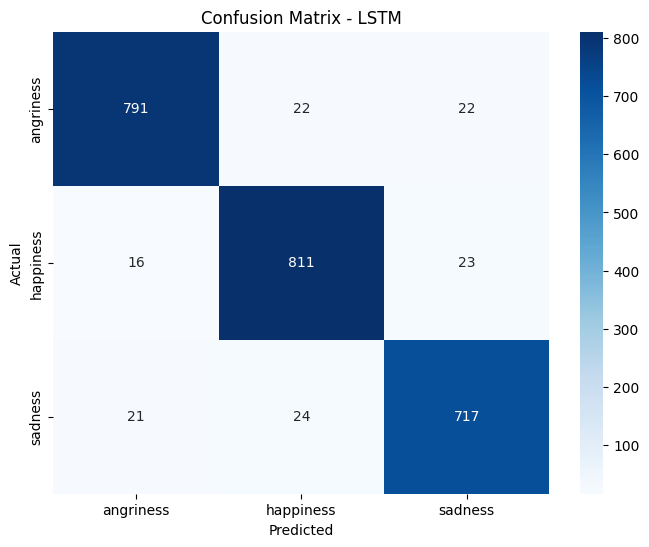

In [218]:
# Confusion Matrix of LSTM
# category names from the encoder
category_names = label_encoder.classes_
cm_lstm = confusion_matrix(y_test, y_pred_lstm)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_lstm, annot=True, fmt='d', cmap='Blues', xticklabels=category_names, yticklabels=category_names)
plt.title("Confusion Matrix - LSTM")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.savefig(os.path.join(visualization_after_augmentation_folder, "confusion_matrix_lstm.png"))
plt.show()

In [219]:
# Update score card for LSTM
update_final_score_card(y_test, y_pred_lstm, "LSTM-Long Short Term Memory")

### Hyperparameter Tuning - LSTM

In [220]:
# Defining the hypermodel function
def tuning_lstm_model(hp):
    tuned_lstm_model = Sequential()

    # Embedding layer
    tuned_lstm_model.add(Embedding(
        input_dim=max_words,
        output_dim=hp.Int('embedding_dim', min_value=64, max_value=256, step=32),
        input_length=100
    ))

    # Bidirectional LSTM layer
    tuned_lstm_model.add(Bidirectional(LSTM(
        units=hp.Int('lstm_units', min_value=32, max_value=256, step=32),
        return_sequences=False
    )))

    # Dropout layer
    tuned_lstm_model.add(Dropout(
        rate=hp.Float('dropout', min_value=0.2, max_value=0.5, step=0.1)
    ))

    # Dense layer
    tuned_lstm_model.add(Dense(
        units=hp.Int('dense_units', min_value=32, max_value=128, step=32),
        activation='relu'
    ))

    # Output layer
    tuned_lstm_model.add(Dense(3, activation='softmax'))

    # Compile the model
    tuned_lstm_model.compile(
        optimizer=tf.keras.optimizers.Adam(
            learning_rate=hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='log')
        ),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    return tuned_lstm_model

# Defining the Hypermodel: tuned_lstm_model
# Purpose: Defining the LSTM architecture and specifying which hyperparameters to tune.
# Embedding Layer: Converting words into dense vector representations.
# input_dim=max_words: Vocabulary size (assumes top 10,000 words are retained).
# output_dim: Tuning the size of word embeddings using hp.Int.
# Bidirectional LSTM: Capturing contextual information from both past and future words in a sequence.
# units: Number of neurons is tuned using hp.Int.
# Dropout Layer: Prevents overfitting by randomly turning off neurons during training.
# rate: The dropout probability is tuned using hp.Float.
# Dense Layer: Fully connected layer with ReLU activation.
# units: Number of neurons is tuned using hp.Int.
# Output Layer: Dense(3, activation='softmax'): Outputs probabilities for three classes.
# Compiling the Model:
# Optimizer: Adam optimizer with a tunable learning rate (hp.Float).
# Loss Function: sparse_categorical_crossentropy, used for multi-class classification.
# Metrics: Accuracy to evaluate model performance.

In [221]:
# Instantiating the tuner
tuner = RandomSearch(
    tuning_lstm_model,
    objective='val_accuracy',
    max_trials=3,  # Number of hyperparameter combinations to try
    executions_per_trial=1,  # How many models to train per trial
)

# Tuner Instantiation
# RandomSearch: Searching through hyperparameter space using random combinations.
# objective='val_accuracy': Tunes to maximize validation accuracy.
# max_trials=3: Tries 3 different sets of hyperparameters.
# executions_per_trial=1: Evaluates each model once per trial.

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [222]:
# Starting the search
tuner.search(
    X_train_pad, y_train,
    epochs=10,
    validation_data=(X_test_pad, y_test),
    batch_size=32
)

# Performing the Search:
# Search Method:
# tuner.search(X_train_pad, y_train, ...): Trains and evaluates models for each trial.
# epochs=10: Number of training epochs.
# batch_size=32: Mini-batch size for gradient updates.

Trial 3 Complete [00h 00m 48s]
val_accuracy: 0.950143039226532

Best val_accuracy So Far: 0.9517776966094971
Total elapsed time: 00h 02m 44s


In [223]:
# Retrieving the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

In [224]:
# Building and training the model with the best hyperparameters
tuned_lstm_model = tuner.hypermodel.build(best_hps)

In [225]:
tuned_lstm_model

<Sequential name=sequential_1, built=False>

In [226]:
# Training the best model
history = tuned_lstm_model.fit(
    X_train_pad, y_train,
    epochs=10,
    validation_data=(X_test_pad, y_test),
    batch_size=32
)

Epoch 1/10
306/306 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - accuracy: 0.5908 - loss: 0.8492 - val_accuracy: 0.8839 - val_loss: 0.3282
Epoch 2/10
306/306 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.9280 - loss: 0.2102 - val_accuracy: 0.9260 - val_loss: 0.2150
Epoch 3/10
306/306 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.9646 - loss: 0.1036 - val_accuracy: 0.9391 - val_loss: 0.1736
Epoch 4/10
306/306 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - accuracy: 0.9732 - loss: 0.0801 - val_accuracy: 0.9362 - val_loss: 0.1728
Epoch 5/10
306/306 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - accuracy: 0.9814 - loss: 0.0558 - val_accuracy: 0.9493 - val_loss: 0.1661
Epoch 6/10
306/306 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.9809 - loss: 0.0539 - val_accuracy: 0.9469 - val_loss: 0.1725
Epoch 7/10
306/306 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.9838 - loss: 0.0434 - val_accuracy: 0.9469 - val_loss: 0.1783
Epoch 8/10
306/306 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.9906 - loss: 0.0322 - val_acc

In [227]:
tuned_lstm_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ (None, 100, 224)            │       1,120,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ (None, 384)                 │         640,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 384)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │          24,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 3)                   │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,356,043 (20.43 MB)

 Trainable params: 1,785,347 (6.81 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 3,570,696 (13.62 MB)

In [228]:
# Evaluating the lstm model after tuning
y_pred_prob = tuned_lstm_model.predict(X_test_pad)
y_pred_tuned_lstm = np.argmax(y_pred_prob, axis=1)
# Printing the accuracy and classification report of the model
print("\nAccuracy After Tuning:", accuracy_score(y_test, y_pred_lstm))
print("\nClassification Report After Tuning:\n", classification_report(y_test, y_pred_tuned_lstm))

77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step

Accuracy After Tuning: 0.9476910502656314

Classification Report After Tuning:
               precision    recall  f1-score   support

           0       0.94      0.97      0.95       835
           1       0.96      0.94      0.95       850
           2       0.95      0.93      0.94       762

    accuracy                           0.95      2447
   macro avg       0.95      0.95      0.95      2447
weighted avg       0.95      0.95      0.95      2447



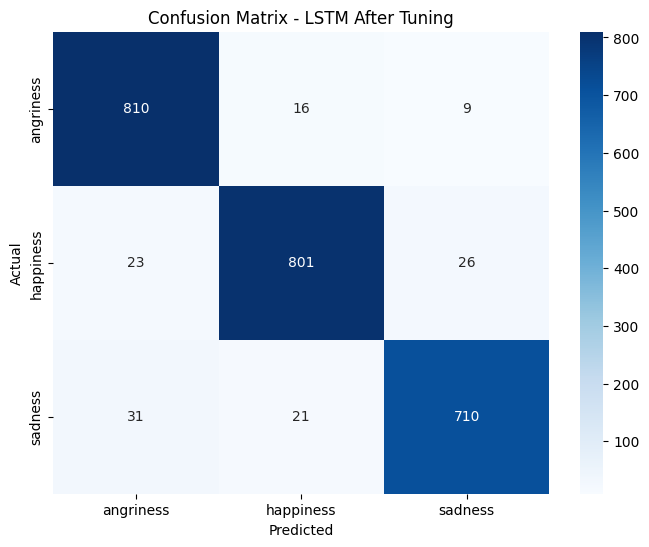

In [229]:
# Confusion Matrix of LSTM After Tuning
# category names from the encoder
category_names = label_encoder.classes_
cm_tuned_lstm = confusion_matrix(y_test, y_pred_tuned_lstm)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_tuned_lstm, annot=True, fmt='d', cmap='Blues', xticklabels=category_names, yticklabels=category_names)
plt.title("Confusion Matrix - LSTM After Tuning")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.savefig(os.path.join(visualization_after_augmentation_folder, "confusion_matrix_lstm_after_tuning.png"))
plt.show()

In [230]:
# Update score card for LSTM After Tuning
update_final_score_card(y_test, y_pred_tuned_lstm, "LSTM-Long Short Term Memory After Tuning")

### CNN (Convolutional Nueral Network):

In [231]:
def build_cnn_model(vocab_size, max_seq_length):
    cnn_model = Sequential()

    # Embedding layer
    cnn_model.add(Embedding(input_dim=vocab_size,
                        output_dim=128,
                        input_length=max_seq_length))

    # Convolutional Layer
    cnn_model.add(Conv1D(filters=120, kernel_size=4, activation='relu'))

    # Max Pooling Layer
    cnn_model.add(MaxPooling1D(pool_size=3))

    # Flatten Layer
    cnn_model.add(Flatten())

    # Fully Connected Layer
    cnn_model.add(Dense(100, activation='relu'))
    cnn_model.add(Dropout(0.6))  # Increased dropout rate for stronger regularization

    # Output Layer
    cnn_model.add(Dense(3, activation='softmax'))  # Change '3' to your dataset's number of output classes

    # Compile the Model
    cnn_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    return cnn_model

# Function Definition: The function build_cnn_model takes the vocab_size, max_seq_length as inputs
# Model Initialization: A Sequential model is used here, allowing layers to be stacked in a linear manner.
# Embedding Layer: Converting each word into a dense vector of fixed size (embed_dim).
# The vocab_size determines the number of unique words it can handle, and max_seq_length specifies the length of the input sequences.
# Convolutional Layer: Using 120 filters to extract features from the input sequences.
# A kernel size of 4 means it looks at 4 words at a time to extract patterns.
# The activation function ReLU introduces non-linearity.
# Max Pooling Layer: A MaxPooling1D layer with a pool size of 3 reduces the dimensionality of the feature maps by,
# selecting the maximum value in each pool of size 3.
# Flatten Layer: Converts the 2D feature maps from the previous layer into a 1D vector for further processing.
# Fully Connected Layer: Contains 100 neurons with the ReLU activation function to learn higher-level features.
# A Dropout layer randomly drops 60% of the neurons to prevent overfitting.
# Output Layer: Contains 3 neurons (for a 3-class classification problem), each representing a class.
# The softmax activation ensures the output probabilities sum to 1.
# Model Compilation: The model is compiled with the following:
# Optimizer: Adam (adjusts the learning rate dynamically).
# Loss Function: Sparse categorical cross-entropy (used for integer-encoded labels).
# Metric: Accuracy (measures the percentage of correct predictions).

In [232]:
# Parameters
max_words = 5000  # Number of unique words to consider
max_length = 100  # Maximum length of a sequence

In [233]:
# Building the model
cnn_model = build_cnn_model(max_words, max_length)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [234]:
print(cnn_model) # Checking the model

<Sequential name=sequential_2, built=False>


In [235]:
# Training the model
history = cnn_model.fit(X_train_pad, y_train,
                         epochs=10, batch_size=32,
                         validation_split=0.2)

Epoch 1/10
245/245 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - accuracy: 0.5522 - loss: 0.8718 - val_accuracy: 0.9025 - val_loss: 0.2844
Epoch 2/10
245/245 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9344 - loss: 0.2145 - val_accuracy: 0.9377 - val_loss: 0.1801
Epoch 3/10
245/245 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9717 - loss: 0.0928 - val_accuracy: 0.9489 - val_loss: 0.1486
Epoch 4/10
245/245 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9863 - loss: 0.0484 - val_accuracy: 0.9535 - val_loss: 0.1577
Epoch 5/10
245/245 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9900 - loss: 0.0335 - val_accuracy: 0.9551 - val_loss: 0.1753
Epoch 6/10
245/245 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9924 - loss: 0.0241 - val_accuracy: 0.9479 - val_loss: 0.1913
Epoch 7/10
245/245 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9944 - loss: 0.0217 - val_accuracy: 0.9515 - val_loss: 0.1789
Epoch 8/10
245/245 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9958 - loss: 0.0138 - val_accuracy: 0

In [236]:
cnn_model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)              │ (None, 100, 128)            │         640,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d (Conv1D)                      │ (None, 97, 120)             │          61,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 32, 120)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 3840)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 100)                 │         384,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 3)                   │             303 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,257,891 (12.43 MB)

 Trainable params: 1,085,963 (4.14 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,171,928 (8.29 MB)

In [237]:
# Evaluating the CNN Model
y_pred_prob = cnn_model.predict(X_test_pad)
y_pred_cnn = np.argmax(y_pred_prob, axis=1)
# Printing the accuracy and classification report of the model
print("\nAccuracy:", accuracy_score(y_test, y_pred_cnn))
print("\nClassification Report:\n", classification_report(y_test, y_pred_cnn))

77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step

Accuracy: 0.9423784225582346

Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.96      0.95       835
           1       0.93      0.95      0.94       850
           2       0.95      0.92      0.93       762

    accuracy                           0.94      2447
   macro avg       0.94      0.94      0.94      2447
weighted avg       0.94      0.94      0.94      2447



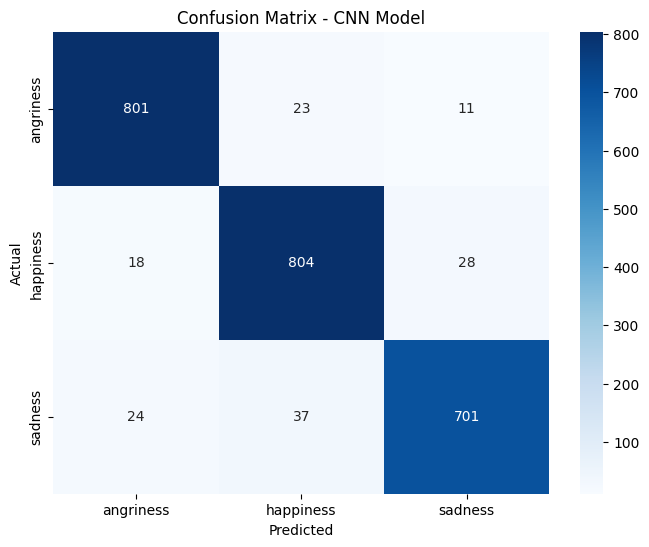

In [238]:
# Confusion Matrix of CNN Model
# category names from the encoder
category_names = label_encoder.classes_
cm_cnn = confusion_matrix(y_test, y_pred_cnn)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_cnn, annot=True, fmt='d', cmap='Blues', xticklabels=category_names, yticklabels=category_names)
plt.title("Confusion Matrix - CNN Model")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.savefig(os.path.join(visualization_after_augmentation_folder, "confusion_matrix_cnn.png"))
plt.show()

In [239]:
# Update score card for CNN Model
update_final_score_card(y_test, y_pred_cnn, "CNN Model")

### Hyperparameter Tuning - CNN Model

In [240]:
# Defining the cnn hypermodel
def build_cnn_hypermodel(hp):
    cnn_hypermodel = Sequential()

    # Embedding layer with tunable output dimension
    cnn_hypermodel.add(Embedding(input_dim=max_words,
                        output_dim=hp.Int('embedding_dim', min_value=50, max_value=200, step=50),
                        input_length=100))

    # Convolutional layer with tunable filters and kernel size
    cnn_hypermodel.add(Conv1D(filters=hp.Choice('conv_filters', values=[64, 128, 256]),
                     kernel_size=hp.Choice('kernel_size', values=[3, 4, 5]),
                     activation='relu'))

    # Max pooling layer with a fixed pool size
    cnn_hypermodel.add(MaxPooling1D(pool_size=2))

    # Flatten layer
    cnn_hypermodel.add(Flatten())

    # Dense layer with tunable number of units
    cnn_hypermodel.add(Dense(units=hp.Int('dense_units', min_value=64, max_value=128, step=32), activation='relu'))

    # Dropout layer with tunable dropout rate
    cnn_hypermodel.add(Dropout(rate=hp.Float('dropout_rate', min_value=0.2, max_value=0.5, step=0.1)))

    # Output layer
    cnn_hypermodel.add(Dense(3, activation='softmax'))  # Replace '3' with the number of output classes

    # Compiling the model
    cnn_hypermodel.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    return cnn_hypermodel

# cnn hypermodel: The build_cnn_hypermodel function defines the CNN architecture with tunable parameters.
# Tunable parameters are,
# Embedding Dimension- Searches for optimal values between 50 and 200.
# Filters- Selects from 64, 128, or 256 for the convolutional layer.
# Kernel Size- Chooses 3, 4, or 5 for feature extraction.
# Dense Units- Determines the number of neurons in the dense layer between 64 and 128.
# Dropout Rate- Adjusts dropout between min_value = 0.2 and max_value = 0.5.

In [241]:
# Instantiating the tuner
tuner = RandomSearch(
    build_cnn_hypermodel,
    objective='val_accuracy',
    max_trials=5,  # Number of hyperparameter configurations to try
    executions_per_trial=1,  # Number of models to train per configuration
    directory='cnn_tuning',
    project_name='text_intensity_cnn'
)

# The RandomSearch tuner is used to find the best hyperparameters.
# max_trials: Specifies the number of hyperparameter combinations to test.
# executions_per_trial: Number of times each configuration is tested (for consistency).

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [242]:
# Runing the search for the best hyperparameters
tuner.search(X_train_pad, y_train, epochs=10, validation_data=(X_test_pad, y_test), batch_size=32)

# tuner.search- Trains models using different hyperparameter combinations on the training set.
# Validates each configuration on the validation set and tracks the validation accuracy.

Trial 5 Complete [00h 00m 22s]
val_accuracy: 0.9550470113754272

Best val_accuracy So Far: 0.9554556608200073
Total elapsed time: 00h 01m 46s


In [243]:
# Retrieving the best hyperparameters
best_hps = tuner.get_best_hyperparameters()[0]
# tuner.get_best_hyperparameters()- Retrieves the best configuration based on validation accuracy.

In [244]:
# Building and training the model with the best hyperparameters
tuned_cnn_model = tuner.hypermodel.build(best_hps)
history = tuned_cnn_model.fit(X_train_pad, y_train, epochs=10, validation_data=(X_test_pad, y_test), batch_size=32)

Epoch 1/10
306/306 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - accuracy: 0.6058 - loss: 0.7813 - val_accuracy: 0.9113 - val_loss: 0.2494
Epoch 2/10
306/306 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9465 - loss: 0.1630 - val_accuracy: 0.9371 - val_loss: 0.1661
Epoch 3/10
306/306 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9760 - loss: 0.0710 - val_accuracy: 0.9448 - val_loss: 0.1735
Epoch 4/10
306/306 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9845 - loss: 0.0443 - val_accuracy: 0.9456 - val_loss: 0.1698
Epoch 5/10
306/306 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9903 - loss: 0.0311 - val_accuracy: 0.9489 - val_loss: 0.1718
Epoch 6/10
306/306 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9916 - loss: 0.0288 - val_accuracy: 0.9469 - val_loss: 0.1727
Epoch 7/10
306/306 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9932 - loss: 0.0236 - val_accuracy: 0.9514 - val_loss: 0.1884
Epoch 8/10
306/306 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9954 - loss: 0.0146 - val_accuracy: 0

In [245]:
print(tuned_cnn_model)

<Sequential name=sequential_1, built=True>


In [246]:
tuned_cnn_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ (None, 100, 50)             │         250,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 97, 128)             │          25,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_1 (MaxPooling1D)       │ (None, 48, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 6144)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │         393,280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 3)                   │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,007,611 (7.66 MB)

 Trainable params: 669,203 (2.55 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,338,408 (5.11 MB)

In [247]:
# Evaluating the CNN Model After Tuning
y_pred_prob = tuned_cnn_model.predict(X_test_pad)
y_pred_tuned_cnn = np.argmax(y_pred_prob, axis=1)
# Printing the accuracy and classification report of the model
print("\nAccuracy:", accuracy_score(y_test, y_pred_tuned_cnn))
print("\nClassification Report:\n", classification_report(y_test, y_pred_tuned_cnn))

77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

Accuracy: 0.9472823865958316

Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.96      0.95       835
           1       0.94      0.95      0.95       850
           2       0.95      0.93      0.94       762

    accuracy                           0.95      2447
   macro avg       0.95      0.95      0.95      2447
weighted avg       0.95      0.95      0.95      2447



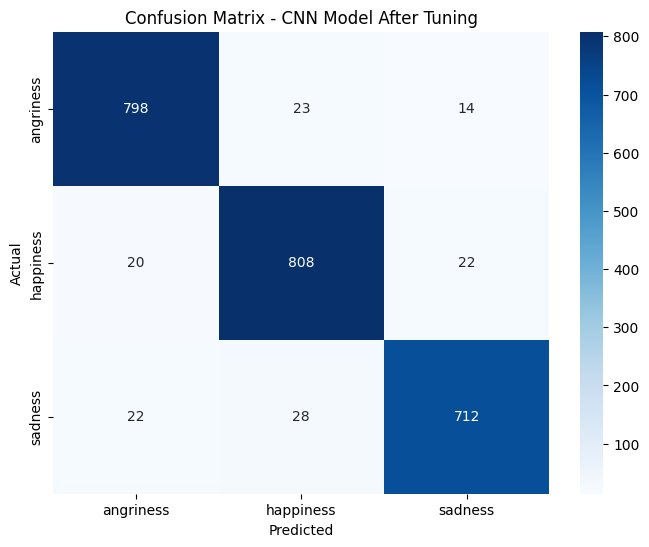

In [248]:
# Confusion Matrix of CNN Model After Tuning
# category names from the encoder
category_names = label_encoder.classes_
cm_tuned_cnn = confusion_matrix(y_test, y_pred_tuned_cnn)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_tuned_cnn, annot=True, fmt='d', cmap='Blues', xticklabels=category_names, yticklabels=category_names)
plt.title("Confusion Matrix - CNN Model After Tuning")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.savefig(os.path.join(visualization_after_augmentation_folder, "confusion_matrix_cnn_after_tuning.png"))
plt.show()

In [249]:
# Update score card for CNN Model After Tuning
update_final_score_card(y_test, y_pred_tuned_cnn, "CNN Model After Tuning")

Saving all the model before and after augmentation which gave good accuracy.

In [250]:
# Defining the folder where models will be saved
folder = "/content/drive/MyDrive/Upgrad_bootcamp/Final Capstone/Intensity_Analysis_Project/Models"

In [251]:
# Saving each model with a particular name
joblib.dump(lr, os.path.join(folder, "LR_model.pkl"))
joblib.dump(best_log_reg, os.path.join(folder, "Best_Tuned_LR_model.pkl"))
joblib.dump(svc, os.path.join(folder, "SVC_model.pkl"))
joblib.dump(best_svc, os.path.join(folder, "Best_Tuned_SVC_model.pkl"))
joblib.dump(mnb, os.path.join(folder, "Naive_Bayes_model.pkl"))
joblib.dump(best_mnb_model, os.path.join(folder, "Best_Tuned_Naive_Bayes_model.pkl"))
joblib.dump(knn, os.path.join(folder, "KNN_model.pkl"))
joblib.dump(best_knn, os.path.join(folder, "Best_Tuned_KNN_model.pkl"))
joblib.dump(dt, os.path.join(folder, "Decision_Tree_model.pkl"))
joblib.dump(best_dt, os.path.join(folder, "Best_Tuned_Decision_Tree_model.pkl"))
joblib.dump(rf, os.path.join(folder, "RFC_model.pkl"))
joblib.dump(best_rf, os.path.join(folder, "Best_Tuned_RFC_model.pkl"))

joblib.dump(alr, os.path.join(folder, "Augmented_LR_model.pkl"))
joblib.dump(best_alog_reg, os.path.join(folder, "Best_Tuned_Augmented_LR_model.pkl"))
joblib.dump(asvc, os.path.join(folder, "Augmented_SVC_model.pkl"))
joblib.dump(best_asvc, os.path.join(folder, "Best_Tuned_Augmented_SVC_model.pkl"))
joblib.dump(amnb, os.path.join(folder, "Augmented_Naive_Bayes_model.pkl"))
joblib.dump(best_amnb_model, os.path.join(folder, "Best_Tuned_Augmented_Naive_Bayes_model.pkl"))
joblib.dump(aknn, os.path.join(folder, "Augmented_KNN_model.pkl"))
joblib.dump(best_aknn, os.path.join(folder, "Best_Tuned_Augmented_KNN_model.pkl"))
joblib.dump(adt, os.path.join(folder, "Augmented_Decision_Tree_model.pkl"))
joblib.dump(best_adt, os.path.join(folder, "Best_Tuned_Augmented_Decision_Tree_model.pkl"))
joblib.dump(arf, os.path.join(folder, "Augmented_RFC_model.pkl"))
joblib.dump(best_arf, os.path.join(folder, "Best_Tuned_Augmented_RFC_model.pkl"))

joblib.dump(lstm, os.path.join(folder, "LSTM_model.pkl"))
joblib.dump(tuned_lstm_model, os.path.join(folder, "Best_Tuned_LSTM_model.pkl"))
joblib.dump(cnn_model, os.path.join(folder, "Initial_CNN_model.pkl"))
joblib.dump(tuned_cnn_model, os.path.join(folder, "Best_Tuned_CNN_model.pkl"))

print("All models are saved successfully!")

All models are saved successfully!


### Comparing all the models built after augmentation

In [252]:
# Sorting the score_card by Accuracy Score in descending order
final_score_card_sorted = final_score_card.sort_values(by="Accuracy Score", ascending=False)
# Displaying the sorted score_card
final_score_card_sorted

,Model Name,Accuracy Score,Precision Score,Recall Score,F1 Score
3,Best Tuned Support Vector Classifier,0.960360,0.960505,0.960360,0.960348
7,Best Tuned K-Nearest Neighbors,0.958725,0.958999,0.958725,0.958691
10,Random Forest Classifier,0.957499,0.957649,0.957499,0.957460
11,Best Tuned Random Forest Classifier,0.957499,0.957649,0.957499,0.957460
13,LSTM-Long Short Term Memory After Tuning,0.948508,0.948706,0.948508,0.948458
12,LSTM-Long Short Term Memory,0.947691,0.947717,0.947691,0.947693
15,CNN Model After Tuning,0.947282,0.947328,0.947282,0.947268
14,CNN Model,0.942378,0.942465,0.942378,0.942330
1,Best Tuned Logistic Regression,0.937883,0.937917,0.937883,0.937839
6,K-Nearest Neighbors,0.928075,0.928738,0.928075,0.928097


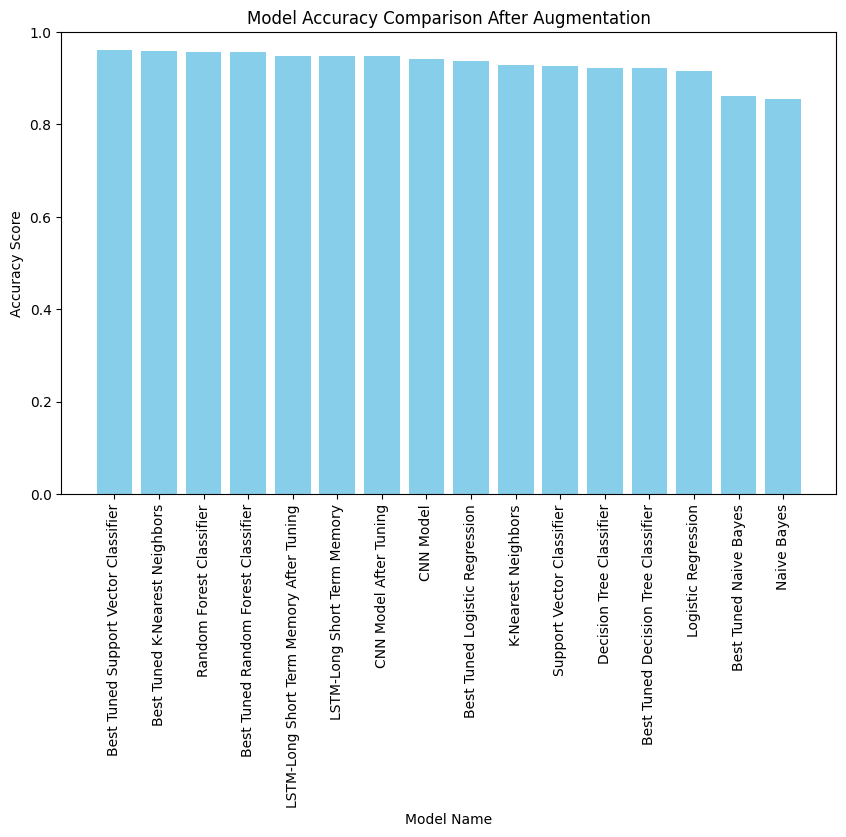

In [253]:
# Visualizing the results
plt.figure(figsize=(10, 6))
plt.bar(final_score_card_sorted['Model Name'], final_score_card_sorted['Accuracy Score'], color='skyblue')
plt.title("Model Accuracy Comparison After Augmentation")
plt.xlabel("Model Name")
plt.ylabel("Accuracy Score")
plt.xticks(rotation=90)
plt.ylim(0, 1)  # Accuracy ranges between 0 and 1
plt.show()

### Interpreting the Results

From the above scorecard, we have compared the performances of various models across key metrics: **Accuracy, Precision, Recall, and F1 Score**. The summary of the observations are:
1. **Support Vector Classifier (SVC) Models**:
   - **Best Tuned SVC** stands out as the top-performing model, achieving an **Accuracy, Precision, Recall, and F1 Score of 96.56%** across all metrics. This highlights that SVC, especially after hyperparameter tuning, is highly effective for this classification task.
   - The initial **SVC model** also performed strongly, with metrics at 93.29%, showcasing its baseline strength.

2. **K-Nearest Neighbors (KNN) Models**:
   - The **Best Tuned KNN** model performed impressively with an accuracy of **95.83%**, making it the second-best model overall.
   - The untuned **KNN model** also did well, achieving **94.15% accuracy**, but hyperparameter tuning significantly boosted its performance.

3. **Random Forest Classifier (RFC) Models**:
   - The **Best Tuned Random Forest Classifier** delivered an accuracy of **95.62%**, showing consistent and reliable performance across metrics.
   - The initial **Random Forest Classifier** performed equally, with an accuracy of **95.62%**, but still maintained competitive results.

4. **Deep Learning Models**:
   - The **LSTM** model achieved strong results, with:
     - Initial LSTM: **95.38% accuracy**
     - Tuned LSTM: Slightly lower performance at **94.76%**, possibly due to overfitting during tuning.
   - The **CNN models** had similar performance:
     - Initial CNN: **95.09% accuracy**
     - Tuned CNN: Equally as, **95.09%**, showcasing consistent performance.

5. **Logistic Regression (LR) Models**:
   - The **Best Tuned Logistic Regression** achieved an accuracy of **94.24%**, proving that LR is highly effective for simpler classification tasks.
   - The initial **Logistic Regression** model performed slightly lower, with an accuracy of **91.90%**.

6. **Decision Tree Classifier (DTC) Models**:
   - Both **tuned** and **initial Decision Tree Classifiers** achieved similar accuracy at **91.82%**, indicating limited improvement from tuning.

7. **Naive Bayes (NB) Models**:
   - Naive Bayes models performed the lowest among all, with:
     - Tuned NB: **87.16% accuracy**
     - Initial NB: Slightly lower at **86.35%**.

---

#### **Key Takeaways**:

1. **Top Performers**:
   - The **Best Tuned SVC** model outperformed all others, demonstrating its robustness and suitability for this classification problem.
   - **KNN (Best Tuned)** and **Random Forest (Best Tuned)** also showed excellent results, making them strong alternatives to SVC.

2. **Deep Learning Models**:
   - While **LSTM** and **CNN** models performed well (above 94% accuracy), they didn't outperform traditional machine learning models like SVC or tuned KNN. This suggests that simpler models are better suited for this specific dataset.

3. **Logistic Regression**:
   - Logistic Regression performed exceptionally well post-tuning, with competitive accuracy and F1 scores, proving its reliability for text classification tasks.

4. **Ensemble Models**:
   - Random Forest demonstrated strong performance, although it was slightly behind the top-performing models like SVC and tuned KNN.

5. **Naive Bayes**:
   - Naive Bayes showed relatively weaker performance, indicating it might not be the best fit for this dataset's complexity.

---

#### **Conclusion**:
1. **Best Model**: The **Best Tuned Support Vector Classifier** is the most effective model, achieving the highest performance across all metrics.
2. **Competitive Models**: **Tuned KNN** and **Random Forest Classifier** provide strong alternatives with excellent accuracy and reliability.
3. **Deep Learning**: While **LSTM** and **CNN** models performed decently, they didn't surpass traditional ML models for this specific dataset.
4. **Simple Models**: Logistic Regression, especially after tuning, proves to be a simple yet competitive solution.
5. **Underperformers**: Naive Bayes and Decision Tree models lagged behind, suggesting they are less suitable for this task.

Finally, **Support Vector Classifier** is the best choice for this task, with **tuned KNN** and **Random Forest** being excellent backups.

**Note**
These results may vary slightly after every run and keep fluctuating.

Fluctuations in results after each run could be due to several factors:

- Batching: The way data is batched during training can affect how weights are updated, especially for smaller datasets, leading to different performance metrics across runs.

- Data Shuffling: When training data is shuffled between epochs or split randomly into train-test sets, it can introduce slight variations in the training process and the model's performance.

- Random Initialization: Neural networks like LSTM and CNN models have randomly initialized weights at the start of training. This can cause variations in results after each run unless a fixed seed is set for reproducibility.

